# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#

In [2]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, make_scorer, f1_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [3]:
pd.set_option('display.float_format', '{:,.3f}'.format) #to set full numbers, not short version -Also with the , notation in numbers

In [4]:
# Find optimal threshold using precision-recall curve
from sklearn.metrics import precision_recall_curve

In [5]:
ecom_df = pd.read_csv('ecom_df.csv')
ecom_df.head()

,date,productid,productname,storecode,storename,first_cat,second_cat,third_cat,industry,have_accountmanager,avg_item_price,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D
0,2020-11-11,"1,730,000,000,000,000,000.000",BĂNG ĐÔ rửa mặt phong cách hàn quốc dễ thương,VNLC3FWH8X,Tiip Gia Dụng,Fashion Accessories,Hair Accessories,Headbands,Fashion,0,0.750,1.503,1.503,0.000,0.000,1.503,0.000,0.000,0.000
1,2020-11-11,"1,730,000,000,000,000,000.000",Bổ Sung Vitamin Germomvit Khoáng Chất Cho Bà...,VNLCNYWLH4,Ba Nấm,Health,Food Supplements,Wellness Supplements,Personal Care & Health,1,11.640,23.285,11.068,12.218,0.000,23.285,0.000,0.000,0.000
2,2020-11-11,"1,730,000,000,000,000,000.000","CINE SET: bộ áo, váy thiết kế Charm By Tea.",VNLCKTWLY7,Charmbytea,Womenswear & Underwear,Women's Suits & Overalls,Sets,Fashion,1,16.330,16.329,16.329,0.000,0.000,0.000,16.329,0.000,0.000
3,2020-11-11,"1,730,000,000,000,000,000.000",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.340,30.678,0.000,0.000,30.678,0.000,0.000,0.000,0.000
4,2020-11-11,"1,730,000,000,000,000,000.000",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.560,15.565,0.000,0.000,0.000,15.565,0.000,15.565,15.565


In [6]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424544 entries, 0 to 2424543
Data columns (total 19 columns):
 #   Column               Dtype  
---  ------               -----  
 0   date                 object 
 1   productid            float64
 2   productname          object 
 3   storecode            object 
 4   storename            object 
 5   first_cat            object 
 6   second_cat           object 
 7   third_cat            object 
 8   industry             object 
 9   have_accountmanager  int64  
 10  avg_item_price       float64
 11  GMV                  float64
 12  GMV_marketplace      float64
 13  GMV_affiliate        float64
 14  GMV_live             float64
 15  GMV_product_card     float64
 16  GMV_video            float64
 17  GMV_Cancel_1D        float64
 18  GMV_Cancel_30D       float64
dtypes: float64(10), int64(1), object(8)
memory usage: 351.5+ MB


In [7]:
# Convert the 'date' column to datetime objects
ecom_df['date'] = pd.to_datetime(ecom_df['date'])

# Now you should be able to access the .dt accessor:
ecom_df['date'].dt.month.value_counts()

#Fix typo
ecom_df['second_cat'] = ecom_df['second_cat'].replace('Large & Home Appliances', 'Large Home Appliances')

# 0-Structure

0-Structure & Define Problems

1-EDA

2-Answer Questions: How much %Cancellation is considered as High

3-Data Transformation

4-Baseline Model

5-Upsampling

6-Model Training

7-Interpretion & Save Model

8-Clustering

9-Cluster Analysis & Recommendation

Define Problems:

* A big Online E-commerce Marketplace - 'E-com Hub' (EH) faced an increasing %cancellation in every Double-Day Campaigns. This leaded to increasing cost of operations, delivery & impacted negatively on P&L (Profit & Loss) of the company
* EH after doing some interviews, realized 2 main reasons that could lead to this situation:

(1) Users are Resellers, who leveraged the vouchers in special campaigns to buy mobile phones & resell to other customers

(2) Some stores intentionally increased GMV (revenue) by fake orders to achieve target bonus, then cancelled

* Dataset: we have GMV performance of store level in D8 (Double-Day campaign 8.8), 1 to 30.9, D10, D11, D12 and 6-11.12 of Year 2020


* Requirement:

Part 1: Prediction
(1) Describe EH business performances and characteristics. How are GMV Marketplace (the listing channel), GMV Affiliate (GMV from KOL/KOC Affiliate channel) and GMV Live (GMV from Livestream channel)

(2) Identify which %Cancellation rate is highly alarmed!

(3) Build ML models to predict stores that likely to have High Cancellation Rate

(4) Evaluate different model performance and translate into insights, what features that detect the most likely high %cancellation rate

Part 2: Cluster Analysis
(5) Please Clustering our data, draw-out some insights and recommendations for each Cluster

# 1-EDA

In [8]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424544 entries, 0 to 2424543
Data columns (total 19 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   productid            float64       
 2   productname          object        
 3   storecode            object        
 4   storename            object        
 5   first_cat            object        
 6   second_cat           object        
 7   third_cat            object        
 8   industry             object        
 9   have_accountmanager  int64         
 10  avg_item_price       float64       
 11  GMV                  float64       
 12  GMV_marketplace      float64       
 13  GMV_affiliate        float64       
 14  GMV_live             float64       
 15  GMV_product_card     float64       
 16  GMV_video            float64       
 17  GMV_Cancel_1D        float64       
 18  GMV_Cancel_30D       float64       
dtypes: datetime64[ns](1),

Features Explaination:
* first_cat, second_cat: level of product categories
* is_having_accountmanager: that store is managed by an Account Manager from EH. Yes = 1, No = 0
* GMV: Revenue, GMV_after_1D: GMV minus cancellation after 1 day, GMV_after_30D: after 30 days
* GMV_marketplace: GMV from listing channel. Remember: GMV include many channels - Livestream, Marketplace, Affiliate, etc.
* GMV_affiliate: GMV from affiliate channel - KOL/KOC's livestreaming, etc.

In [9]:
 ecom_df.describe()

,date,productid,have_accountmanager,avg_item_price,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D
count,2424544,"2,424,544.000","2,424,544.000","2,424,163.000","2,424,544.000","2,424,544.000","2,424,544.000","2,424,544.000","2,424,544.000","2,424,544.000","2,424,544.000","2,424,544.000"
mean,2020-11-01 02:49:00.350020864,"1,729,965,493,222,642,944.000",0.726,8.710,39.719,9.615,14.016,18.758,13.524,7.437,8.500,11.087
min,2020-08-08 00:00:00,"1,729,380,000,000,000,000.000",0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000
25%,2020-09-21 00:00:00,"1,730,000,000,000,000,000.000",0.000,2.862,4.108,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,2020-11-11 00:00:00,"1,730,000,000,000,000,000.000",1.000,5.260,8.303,0.000,0.000,0.000,2.333,0.000,0.000,0.000
75%,2020-12-07 00:00:00,"1,730,000,000,000,000,000.000",1.000,8.805,20.513,5.566,2.628,3.384,7.885,1.235,2.410,4.623
max,2020-12-12 00:00:00,"1,730,000,000,000,000,000.000",1.000,"4,390.960","489,290.925","237,988.250","87,385.349","445,843.114","237,944.678","45,412.220","68,899.664","68,899.664"
std,NaN,"110,570,001,229,455.891",0.446,24.548,703.999,316.187,208.288,577.497,315.544,85.119,149.032,177.681


Questions in mind:
- GMV by Cat: What is the structure of First Cat- Second Cat, What are the most selling cat, Are there different by trend?
- How many stores have account manager
- What are the GMV trend in each D-Day campaigns, from 8.8 to 12.12? Same with GMV_marketplace, affiliate and orders
- Is there anything about AOV differences (Average Order Value = GMV / Orders)
- What is the cancellation trend (after_1D, after_30D) between normal days, and D-Day campaigns
- Should we segment GMV by tier?

## 1-1 GMV by Industry - First Cat

In [10]:
#Structure of First Cat - Second Cat
GMV_By_First_Cat = ecom_df.groupby(['industry', 'first_cat']).agg({'GMV': 'sum'})/ ( ecom_df['GMV'].sum() ) * 100
GMV_By_First_Cat.sort_values(by=['industry', 'GMV'], ascending=False)

GMV
industry               first_cat                               
Personal Care & Health Beauty & Personal Care             5.099
                       Health                             2.350
                       Home Supplies                      0.334
Mom & Babies           Baby & Maternity                   5.040
                       Kids' Fashion                      0.982
                       Toys & Hobbies                     0.317
Home & Living          Automotive & Motorcycle            1.491
                       Home Supplies                      1.250
                       Textiles & Soft Furnishings        1.086
                       Kitchenware                        0.841
                       Home Improvement                   0.672
                       Tools & Hardware                   0.595
                       Pet Supplies                       0.423
                       Furniture                          0.377
                       Toys & Hobbies                     0.231
                       Sports & Outdoor                   0.095
                       Collectibles                       0.018
Grocery                Food & Beverages                   3.558
                       Books, Magazines & Audio           0.314
                       Computers & Office Equipment       0.307
                       Home Supplies                      0.266
                       Fashion Accessories                0.032
                       Toys & Hobbies                     0.028
Fashion                Womenswear & Underwear            12.962
                       Menswear & Underwear               6.385
                       Shoes                              2.742
                       Sports & Outdoor                   2.575
                       Fashion Accessories                1.642
                       Luggage & Bags                     1.483
                       Jewelry Accessories & Derivatives  0.275
                       Muslim Fashion                     0.005
Electronics            Phones & Electronics              24.699
                       Household Appliances              11.256
                       Computers & Office Equipment       2.729
Beauty                 Beauty & Personal Care             7.541

- We see that from this dataset, Fashion & Electronics contribute the most GMV, - In Electronics - Phones is 24% GMV and Household Applianices is 11%
- In Fashion it is Womenswear 13%, Menswear 6%
- After that, we have Beauty 7.5% - Personal Care & Health also 7.5%
- Other industries seems to be small


In [11]:
#Lets see GMV Industry Trend

GMV_By_industry_Trend = ecom_df.groupby(['industry', 'date']).agg({'GMV': 'sum'}).unstack().T.droplevel(0) #unstack to unpivot, T to transpose, droplevel(0) to drop the 1st column GMV name (no need)

In [13]:
GMV_By_industry_Trend.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39 entries, 2020-08-08 to 2020-12-12
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Beauty                  7 non-null      float64
 1   Electronics             39 non-null     float64
 2   Fashion                 7 non-null      float64
 3   Grocery                 7 non-null      float64
 4   Home & Living           7 non-null      float64
 5   Mom & Babies            7 non-null      float64
 6   Personal Care & Health  7 non-null      float64
dtypes: float64(7)
memory usage: 2.4 KB


We realize that only Electronics have GMV for the whole Sep, while other industries have GMV in only campaigns D9 (9.9.20) --> Suggest to remove to make it more relevant to forecast only Cancellation rate in Campaign Days

In [14]:
GMV_By_industry_Trend.dropna(inplace = True)

In [15]:
GMV_By_industry_Trend['total_GMV'] = GMV_By_industry_Trend['Beauty'] + GMV_By_industry_Trend['Electronics'] + GMV_By_industry_Trend['Fashion'] + GMV_By_industry_Trend['Grocery']  + GMV_By_industry_Trend['Home & Living'] + GMV_By_industry_Trend['Mom & Babies'] + + GMV_By_industry_Trend['Personal Care & Health']

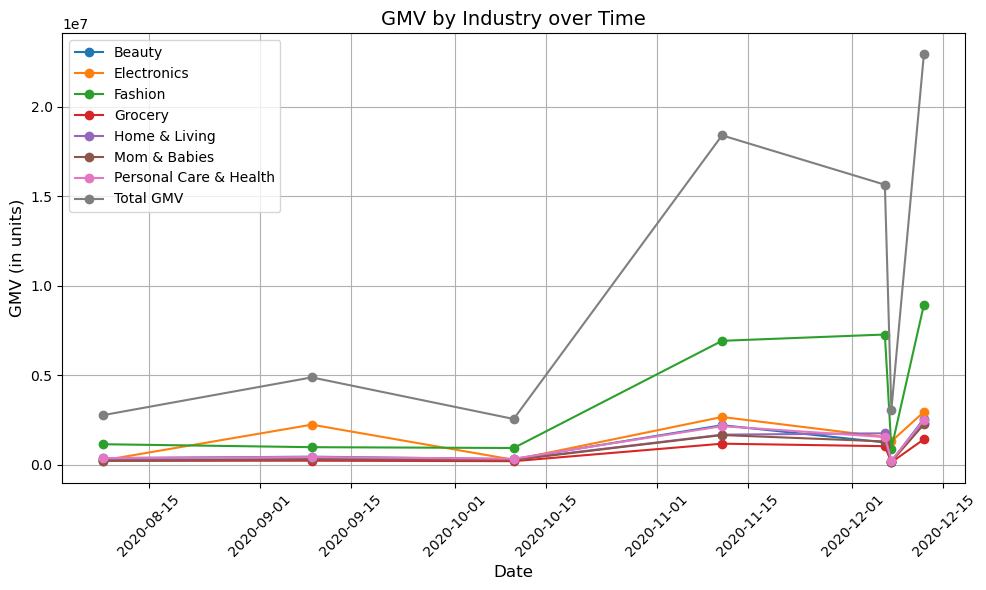

In [16]:
df = GMV_By_industry_Trend
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Beauty'], marker='o', label='Beauty')
plt.plot(df.index, df['Electronics'], marker='o', label='Electronics')
plt.plot(df.index, df['Fashion'], marker='o', label='Fashion')
plt.plot(df.index, df['Grocery'], marker='o', label='Grocery')
plt.plot(df.index, df['Home & Living'], marker='o', label='Home & Living')
plt.plot(df.index, df['Mom & Babies'], marker='o', label='Mom & Babies')
plt.plot(df.index, df['Personal Care & Health'], marker='o', label='Personal Care & Health')
plt.plot(df.index, df['total_GMV'], marker='o', label='Total GMV')

# Beautifying the plot
plt.title('GMV by Industry over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('GMV (in units)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

P/s: Remember that it is not continuous. We have 8.8, 9.9, then 10.10, 11.11, 6-7.16 and 12.12

In [17]:
#I dont want to show e+06 in the .head, I want to see full with ,
GMV_By_industry_Trend.head(10).style.format('{:,.0f}')

industry,Beauty,Electronics,Fashion,Grocery,Home & Living,Mom & Babies,Personal Care & Health,total_GMV
date,,,,,,,,
2020-08-08 00:00:00,"357,334","238,161","1,134,614","207,178","252,950","209,979","362,679","2,762,895"
2020-09-09 00:00:00,"439,677","2,227,995","969,928","214,138","309,273","288,786","418,779","4,868,577"
2020-10-10 00:00:00,"302,280","265,840","923,753","187,924","283,897","257,730","324,092","2,545,515"
2020-11-11 00:00:00,"2,197,458","2,656,778","6,912,429","1,165,086","1,669,093","1,647,773","2,142,580","18,391,197"
2020-12-06 00:00:00,"1,235,895","1,536,793","7,264,167","1,025,287","1,744,373","1,290,007","1,537,849","15,634,369"
2020-12-07 00:00:00,"167,765","1,291,341","888,747","125,261","216,991","160,130","204,332","3,054,568"
2020-12-12 00:00:00,"2,561,609","2,943,140","8,936,983","1,414,098","2,339,640","2,250,340","2,504,449","22,950,259"


Overall, from here we see that very strange movement:
- We start very low in 8.8, 2,7M and and x2 in 9.9 up to 4.8M USD - 50% contributed from Electronics!!!
- Then we see 10.10, we decreased again -2x to 2.5M USD
- 11.11, 6.12 and 12.12 we see a big push of D-Day, respectively 18.4M, 15.6M & 22.9M - Awesome!!!
- 7.12 is just a normal day after campaigns, but still 3M!

From the research with the team, 8.8 was not the peak sales of E-commerce yet, and 10.10 we faced a major system collapse! Thats why we see so low GMV from D8 and D10

About Industry level, we see that big push of GMV coming from Electromics and Fashion.
- Especially Fashion in D11 and D12 (up to 7-9M GMV - contribute 40-50% GMV of campaigns)
- Electronics is also a star in 9.9 when reached 2M GMV while other is only below 1M. Based on market insights, there is a new Iphone Product Launch so many customers pre-order on EH platform
- Other industry perform around 2-2.5M in D12 campaigns


## 1-2 GMV marketplace, affiliate and live trend

In [93]:
#Structure of GMV Contribution
GMV_By_industry_Cont = ecom_df.groupby(['industry']).agg({'GMV': 'sum', 'GMV_affiliate': 'sum', 'GMV_marketplace': 'sum', 'GMV_live': 'sum'})/ ( ecom_df['GMV'].sum() ) * 100
GMV_By_industry_Cont.sort_values(by=['GMV'], ascending=False)

,GMV,GMV_affiliate,GMV_marketplace,GMV_live
industry,,,,
Electronics,38.685,13.820,9.996,20.560
Fashion,28.069,9.437,6.658,12.095
Personal Care & Health,7.783,2.976,1.718,3.382
Beauty,7.541,3.411,1.510,4.042
Home & Living,7.078,2.012,1.824,2.254
Mom & Babies,6.339,2.099,1.625,3.007
Grocery,4.506,1.534,0.878,1.887


In [102]:
GMV_By_industry_Cont = (
    ecom_df.groupby(['industry'])
    .agg({'GMV': 'sum', 'GMV_affiliate': 'sum', 'GMV_marketplace': 'sum', 'GMV_live': 'sum'}) 
    / ecom_df['GMV'].sum() * 100
)

# Sort values by GMV
GMV_By_industry_Cont = GMV_By_industry_Cont.sort_values(by=['GMV'], ascending=False)

# Add a total row at the bottom
GMV_By_industry_Cont.loc['Total'] = GMV_By_industry_Cont.sum()

GMV_By_industry_Cont.round(1)

,GMV,GMV_affiliate,GMV_marketplace,GMV_live
industry,,,,
Electronics,38.700,13.800,10.000,20.600
Fashion,28.100,9.400,6.700,12.100
Personal Care & Health,7.800,3.000,1.700,3.400
Beauty,7.500,3.400,1.500,4.000
Home & Living,7.100,2.000,1.800,2.300
Mom & Babies,6.300,2.100,1.600,3.000
Grocery,4.500,1.500,0.900,1.900
Total,100.000,35.300,24.200,47.200


In this way, we can interpret that:
- Affiliate contribute 35% GMV, while Marketplace contribute 24%. So in this business, we were quite rely heavily on Affiliate (have to pay much to KOL/KOC for affiliate revenue - which contribute 1/3 of our GMV)
- Marketplace channel is still weak. This one is the way that we grow GMV by ourselves but only contribute 1/4 GMV
- As Livestreaming is increasing recently, with Instagram Live, TikTok Shop, etc. Of course, GMV_Live contribute 47% of total GMV. Surprising to me is: Electronics 20% GMV come from livestream, even higher than Fashion (12%) - could be a breakthrough for our business

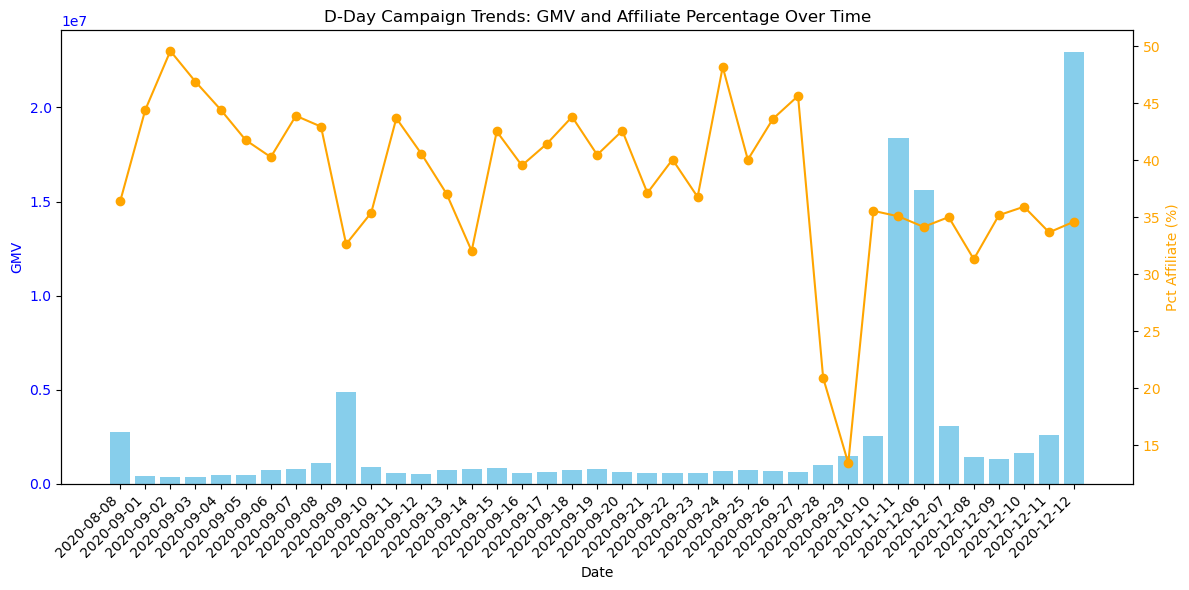

In [ ]:
# Analyse Affiliate Trend
GMV_affliate_Trend = (
    ecom_df.groupby(['date'])
    .agg({'GMV_affiliate': 'sum', 'GMV': 'sum'})
)

# Calculate the affiliate percentage
GMV_affliate_Trend['pct_affiliate'] = GMV_affliate_Trend['GMV_affiliate'] / GMV_affliate_Trend['GMV'] * 100

# Reset index to make 'date' a column again
GMV_affliate_Trend = GMV_affliate_Trend.reset_index()

# Filter out rows where GMV_affiliate or GMV is zero or missing
GMV_affliate_Trend = GMV_affliate_Trend.dropna(subset=['GMV', 'GMV_affiliate'])

# Filter out any rows where GMV or GMV_affiliate is zero (if necessary)
GMV_affliate_Trend = GMV_affliate_Trend[(GMV_affliate_Trend['GMV'] > 0) & (GMV_affliate_Trend['GMV_affiliate'] > 0)]

# Ensure 'date' is treated as an object (string), not a datetime
GMV_affliate_Trend['date'] = GMV_affliate_Trend['date'].astype(str)

# Plotting GMV as bars and pct_affiliate as a line
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot GMV as a bar chart on the primary y-axis
ax1.bar(GMV_affliate_Trend['date'], GMV_affliate_Trend['GMV'], color='skyblue', label='GMV')
ax1.set_xlabel('Date')
ax1.set_ylabel('GMV', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(GMV_affliate_Trend['date'], rotation=45, ha='right')  # Rotate labels for better readability

# Plot pct_affiliate as a line chart on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(GMV_affliate_Trend['date'], GMV_affliate_Trend['pct_affiliate'], color='orange', marker='o', label='Pct Affiliate')
ax2.set_ylabel('Pct Affiliate (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Adding a title and legend
plt.title('D-Day Campaign Trends: GMV and Affiliate Percentage Over Time')
fig.tight_layout()
plt.show()

Regarding Affiliate trend:
- In Normal days, Affiliate quite high, around 30-50%
- In Big D-Day Compaignes like 11.11, 12.12 - Affiliate become healthier - 30-35% which are quite good!

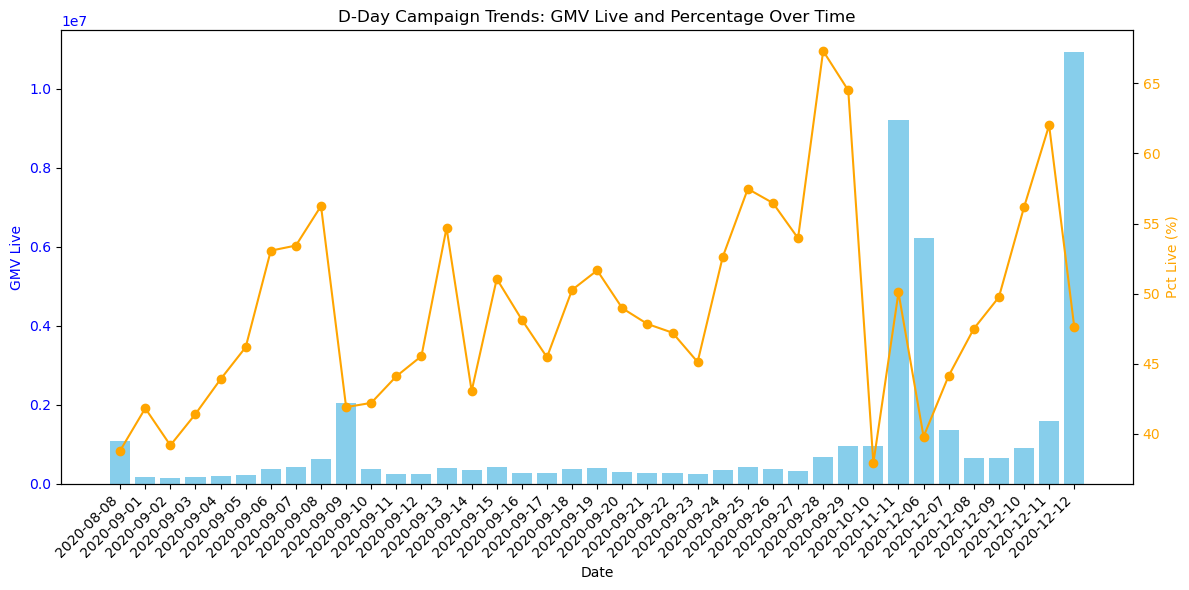

In [118]:
# GMV Live Trend
GMV_live_Trend = (
    ecom_df.groupby(['date'])
    .agg({'GMV_live': 'sum', 'GMV': 'sum'})
)

# Calculate the percentage of GMV_live to GMV
GMV_live_Trend['pct_live'] = GMV_live_Trend['GMV_live'] / GMV_live_Trend['GMV'] * 100

# Reset index to make 'date' a column again
GMV_live_Trend = GMV_live_Trend.reset_index()

# Filter out rows where GMV_live or GMV is zero or missing
GMV_live_Trend = GMV_live_Trend.dropna(subset=['GMV', 'GMV_live'])

# Filter out any rows where GMV or GMV_live is zero (if necessary)
GMV_live_Trend = GMV_live_Trend[(GMV_live_Trend['GMV'] > 0) & (GMV_live_Trend['GMV_live'] > 0)]

# Ensure 'date' is treated as an object (string), not a datetime
GMV_live_Trend['date'] = GMV_live_Trend['date'].astype(str)

# Plotting GMV_live as bars and pct_live as a line
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot GMV_live as a bar chart on the primary y-axis
ax1.bar(GMV_live_Trend['date'], GMV_live_Trend['GMV_live'], color='skyblue', label='GMV Live')
ax1.set_xlabel('Date')
ax1.set_ylabel('GMV Live', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(GMV_live_Trend['date'], rotation=45, ha='right')  # Rotate labels for better readability

# Plot pct_live as a line chart on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(GMV_live_Trend['date'], GMV_live_Trend['pct_live'], color='orange', marker='o', label='Pct Live')
ax2.set_ylabel('Pct Live (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Adding a title and legend
plt.title('D-Day Campaign Trends: GMV Live and Percentage Over Time')
fig.tight_layout()
plt.show()

Regarding Live Trend:
- Absolutely %GMV Live are already high, 40%+
- In Campaign Days, 29.9 , 11.12, 12.12 - %Live increase to 50-60% - Quite high overall - It is a good news that our Merchants (Sellers) are active to livestreaming!

## 1-3 GMV cancellation trend after 1 Day and after 30 Days

In [22]:
#Calculate cancellation trend in overall level, GMV_after_1D, GMV_after_30D

In [23]:
ecom_df.head()

,date,productid,productname,storecode,storename,first_cat,second_cat,third_cat,industry,have_accountmanager,avg_item_price,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D
0,2020-11-11,"1,730,000,000,000,000,000.000",BĂNG ĐÔ rửa mặt phong cách hàn quốc dễ thương,VNLC3FWH8X,Tiip Gia Dụng,Fashion Accessories,Hair Accessories,Headbands,Fashion,0,0.750,1.503,1.503,0.000,0.000,1.503,0.000,0.000,0.000
1,2020-11-11,"1,730,000,000,000,000,000.000",Bổ Sung Vitamin Germomvit Khoáng Chất Cho Bà...,VNLCNYWLH4,Ba Nấm,Health,Food Supplements,Wellness Supplements,Personal Care & Health,1,11.640,23.285,11.068,12.218,0.000,23.285,0.000,0.000,0.000
2,2020-11-11,"1,730,000,000,000,000,000.000","CINE SET: bộ áo, váy thiết kế Charm By Tea.",VNLCKTWLY7,Charmbytea,Womenswear & Underwear,Women's Suits & Overalls,Sets,Fashion,1,16.330,16.329,16.329,0.000,0.000,0.000,16.329,0.000,0.000
3,2020-11-11,"1,730,000,000,000,000,000.000",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.340,30.678,0.000,0.000,30.678,0.000,0.000,0.000,0.000
4,2020-11-11,"1,730,000,000,000,000,000.000",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.560,15.565,0.000,0.000,0.000,15.565,0.000,15.565,15.565


In [24]:
ecom_df_date = ecom_df.groupby(['date']).agg({'GMV': 'sum', 'GMV_Cancel_1D': 'sum', 'GMV_Cancel_30D': 'sum'})
ecom_df_date.head()

,GMV,GMV_Cancel_1D,GMV_Cancel_30D
date,,,
2020-08-08,"2,762,894.772","568,660.015","749,559.376"
2020-09-01,"423,004.124","88,831.063","145,202.867"
2020-09-02,"380,108.960","83,526.867","119,836.333"
2020-09-03,"383,664.804","87,413.549","121,417.947"
2020-09-04,"459,735.988","103,489.435","145,389.003"


In [25]:
#calculate contribution by date level
ecom_df_date['GMV_Cancel_1D_pct'] = ecom_df_date['GMV_Cancel_1D'] / ecom_df_date['GMV'] * 100
ecom_df_date['GMV_Cancel_30D_pct'] = ecom_df_date['GMV_Cancel_30D'] / ecom_df_date['GMV'] * 100

In [26]:
ecom_df_date.head(50)

,GMV,GMV_Cancel_1D,GMV_Cancel_30D,GMV_Cancel_1D_pct,GMV_Cancel_30D_pct
date,,,,,
2020-08-08,"2,762,894.772","568,660.015","749,559.376",20.582,27.129
2020-09-01,"423,004.124","88,831.063","145,202.867",21.000,34.327
2020-09-02,"380,108.960","83,526.867","119,836.333",21.974,31.527
2020-09-03,"383,664.804","87,413.549","121,417.947",22.784,31.647
2020-09-04,"459,735.988","103,489.435","145,389.003",22.511,31.624
2020-09-05,"480,091.609","112,994.063","159,602.067",23.536,33.244
2020-09-06,"718,355.322","186,341.480","245,838.220",25.940,34.222
2020-09-07,"777,294.065","181,102.574","245,818.797",23.299,31.625
2020-09-08,"1,109,210.312","274,570.995","362,468.256",24.754,32.678


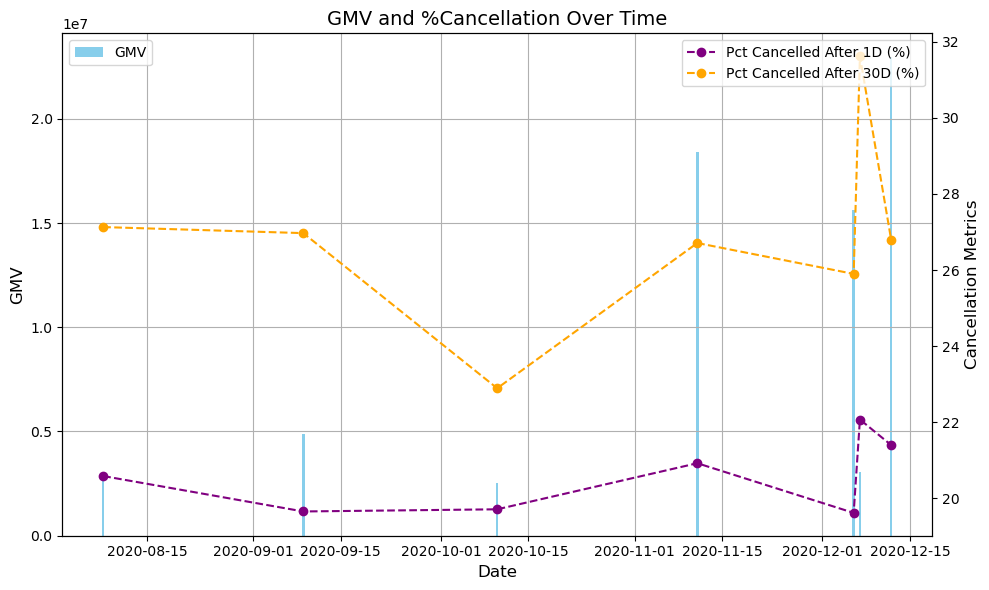

In [27]:
#Now, visualize GMV as bar chart by date, and 2 lines pct_cancelled_after_1D, pct_cancelled_after_30D - Only Take Campaigns Date
campaign_date = ['2020-08-08', '2020-09-09', '2020-10-10', '2020-11-11', '2020-12-06', '2020-12-07', '2020-12-12']

df = ecom_df_date.loc[campaign_date]

# Create a figure and axis with twin y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot GMV as bar chart
ax1.bar(df.index, df['GMV'], color='skyblue', label='GMV', width=0.4)

# Create a secondary y-axis for the lines
ax2 = ax1.twinx()

# Plot the other columns as lines
ax2.plot(df.index, df['GMV_Cancel_1D_pct'], marker='o', label='Pct Cancelled After 1D (%)', color='purple', linestyle='--')
ax2.plot(df.index, df['GMV_Cancel_30D_pct'], marker='o', label='Pct Cancelled After 30D (%)', color='orange', linestyle='--')

# Beautifying the plot
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('GMV', fontsize=12)
ax2.set_ylabel('Cancellation Metrics', fontsize=12)

# Title
plt.title('GMV and %Cancellation Over Time', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adding legends for both plots
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Grid for better readability
ax1.grid(True)

plt.tight_layout()
plt.show()

In [28]:
df.head(10)

,GMV,GMV_Cancel_1D,GMV_Cancel_30D,GMV_Cancel_1D_pct,GMV_Cancel_30D_pct
date,,,,,
2020-08-08,"2,762,894.772","568,660.015","749,559.376",20.582,27.129
2020-09-09,"4,868,577.353","956,701.154","1,313,071.476",19.651,26.970
2020-10-10,"2,545,514.934","501,654.525","582,670.069",19.707,22.890
2020-11-11,"18,391,196.954","3,847,287.689","4,912,242.960",20.919,26.710
2020-12-06,"15,634,369.484","3,066,381.374","4,049,016.293",19.613,25.898
2020-12-07,"3,054,568.235","674,103.483","965,972.173",22.069,31.624
2020-12-12,"22,950,259.347","4,910,303.862","6,148,228.577",21.395,26.789


In [29]:
#Campaign avg. cancellation rate
df.agg({'GMV_Cancel_1D_pct': 'mean', 'GMV_Cancel_30D_pct': 'mean'})

GMV_Cancel_1D_pct    20.562
GMV_Cancel_30D_pct   26.859
dtype: float64

In [30]:
#calculate average cancellation rate in  Normal Date, note Campaign Date
ecom_df_date.loc[
    ((ecom_df_date.index >= '2020-09-01') & (ecom_df_date.index <= '2020-09-08')) |
    ((ecom_df_date.index >= '2020-09-10') & (ecom_df_date.index <= '2020-09-30')) |
    ((ecom_df_date.index >= '2020-12-07') & (ecom_df_date.index <= '2020-12-11'))
].agg({'GMV_Cancel_1D_pct': 'mean', 'GMV_Cancel_30D_pct': 'mean'})

GMV_Cancel_1D_pct    23.432
GMV_Cancel_30D_pct   31.316
dtype: float64

Taking Avg. seems not so trustful, because seems Cancellation rate in Campaigns is lower than normal days:
- Normal GMV_Cancel_1D_pct could be 23%, GMV_Cancel_30D_pct is 31%
- In Campaigns, GMV_Cancel_1D_pct is 20%, GMV_Cancel_30D_pct is 27%

Trend of Cancellation in Campaigns Day:
- The trend of GMV_Cancel_1D_pct in Campaigns days is relatively 20%, but increase in D11 & D12, reaching 22% in D12
- D10 cancellation after 30D is suddenly low at 23% - for the technical issues happenning so it is better than usual. I believe that it should be 26-27% in campaigns. It is very high - 32% in 7.12 (what happenned?)

First assumptions: GMV_Cancel_30D_pct: lets take **30% as Warning Threshold**

# 2-Answer Questions: How much %Cancellation is considered as High

In [31]:
ecom_df.head()

,date,productid,productname,storecode,storename,first_cat,second_cat,third_cat,industry,have_accountmanager,avg_item_price,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D
0,2020-11-11,"1,730,000,000,000,000,000.000",BĂNG ĐÔ rửa mặt phong cách hàn quốc dễ thương,VNLC3FWH8X,Tiip Gia Dụng,Fashion Accessories,Hair Accessories,Headbands,Fashion,0,0.750,1.503,1.503,0.000,0.000,1.503,0.000,0.000,0.000
1,2020-11-11,"1,730,000,000,000,000,000.000",Bổ Sung Vitamin Germomvit Khoáng Chất Cho Bà...,VNLCNYWLH4,Ba Nấm,Health,Food Supplements,Wellness Supplements,Personal Care & Health,1,11.640,23.285,11.068,12.218,0.000,23.285,0.000,0.000,0.000
2,2020-11-11,"1,730,000,000,000,000,000.000","CINE SET: bộ áo, váy thiết kế Charm By Tea.",VNLCKTWLY7,Charmbytea,Womenswear & Underwear,Women's Suits & Overalls,Sets,Fashion,1,16.330,16.329,16.329,0.000,0.000,0.000,16.329,0.000,0.000
3,2020-11-11,"1,730,000,000,000,000,000.000",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.340,30.678,0.000,0.000,30.678,0.000,0.000,0.000,0.000
4,2020-11-11,"1,730,000,000,000,000,000.000",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.560,15.565,0.000,0.000,0.000,15.565,0.000,15.565,15.565


In [32]:
#aggregrate by storecode and date
store_df = ecom_df.groupby(['date', 'storecode']).agg({'GMV': 'sum', 'GMV_Cancel_1D': 'sum', 'GMV_Cancel_30D': 'sum'})
store_df.head()

GMV  GMV_Cancel_1D  GMV_Cancel_30D
date       storecode                                       
2020-08-08 VNLC22LLGV  8.085          0.000           0.000
           VNLC22LLMW 21.529          0.000           0.000
           VNLC22LLUM 23.215          0.000          23.215
           VNLC22LLUN 54.578         10.217          10.217
           VNLC22W2TC  2.925          0.000           2.925

In [33]:
#calculate pct
store_df['GMV_Cancel_1D_pct'] = store_df['GMV_Cancel_1D'] / store_df['GMV'] * 100
store_df['GMV_Cancel_30D_pct'] = store_df['GMV_Cancel_30D'] / store_df['GMV'] * 100
store_df.head()

GMV  GMV_Cancel_1D  GMV_Cancel_30D  \
date       storecode                                          
2020-08-08 VNLC22LLGV  8.085          0.000           0.000   
           VNLC22LLMW 21.529          0.000           0.000   
           VNLC22LLUM 23.215          0.000          23.215   
           VNLC22LLUN 54.578         10.217          10.217   
           VNLC22W2TC  2.925          0.000           2.925   

                       GMV_Cancel_1D_pct  GMV_Cancel_30D_pct  
date       storecode                                          
2020-08-08 VNLC22LLGV              0.000               0.000  
           VNLC22LLMW              0.000               0.000  
           VNLC22LLUM              0.000             100.000  
           VNLC22LLUN             18.720              18.720  
           VNLC22W2TC              0.000             100.000

In [34]:
#reset the index to make 'date' and 'storecode' regular columns:
store_df = store_df.reset_index()
store_df.head()

,date,storecode,GMV,GMV_Cancel_1D,GMV_Cancel_30D,GMV_Cancel_1D_pct,GMV_Cancel_30D_pct
0,2020-08-08,VNLC22LLGV,8.085,0.000,0.000,0.000,0.000
1,2020-08-08,VNLC22LLMW,21.529,0.000,0.000,0.000,0.000
2,2020-08-08,VNLC22LLUM,23.215,0.000,23.215,0.000,100.000
3,2020-08-08,VNLC22LLUN,54.578,10.217,10.217,18.720,18.720
4,2020-08-08,VNLC22W2TC,2.925,0.000,2.925,0.000,100.000


In [35]:
store_df['date'] = pd.to_datetime(store_df['date'])

Now lets see the Cancellation rate of D-Day

In [36]:
#take only the D-Day campaign
store_df_dday = store_df[store_df['date'].isin(campaign_date)]
store_df_dday.describe()

,date,GMV,GMV_Cancel_1D,GMV_Cancel_30D,GMV_Cancel_1D_pct,GMV_Cancel_30D_pct
count,284785,"284,785.000","284,785.000","284,785.000","284,467.000","284,467.000"
mean,2020-11-05 21:51:10.615376384,246.528,51.004,65.736,14.971,23.455
min,2020-08-08 00:00:00,0.000,0.000,0.000,0.000,0.000
25%,2020-10-10 00:00:00,8.428,0.000,0.000,0.000,0.000
50%,2020-12-06 00:00:00,24.234,0.000,4.179,0.000,11.646
75%,2020-12-07 00:00:00,96.158,14.409,20.721,19.403,32.298
max,2020-12-12 00:00:00,"394,127.621","105,669.621","115,827.985",100.000,100.000
std,NaN,"2,330.893",658.990,774.977,25.074,31.691


(array([154513.,  17846.,  23041.,  20046.,  13965.,   9595.,   7391.,
          4985.,   3557.,   3477.,   5004.,   1722.,   1306.,   1336.,
           792.,    597.,    395.,    269.,    194.,  14436.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

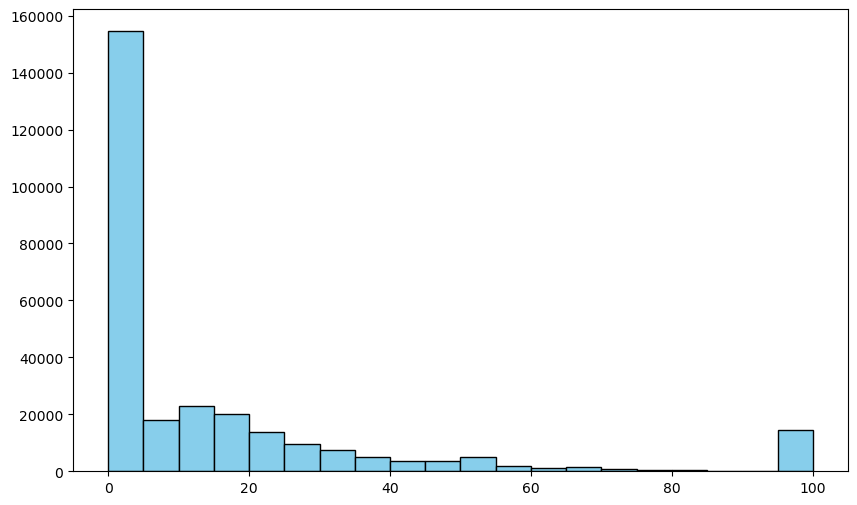

In [37]:
#draw a histogram to see how many stores with different pct_cancelled_after_1D
plt.figure(figsize=(10, 6))
plt.hist(store_df_dday['GMV_Cancel_1D_pct'], bins=20, color='skyblue', edgecolor='black')

(array([124528.,  12072.,  18889.,  21234.,  17980.,  13727.,  10499.,
          7577.,   5457.,   5102.,   6442.,   2696.,   2127.,   2091.,
          1382.,   1057.,    725.,    506.,    318.,  30058.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

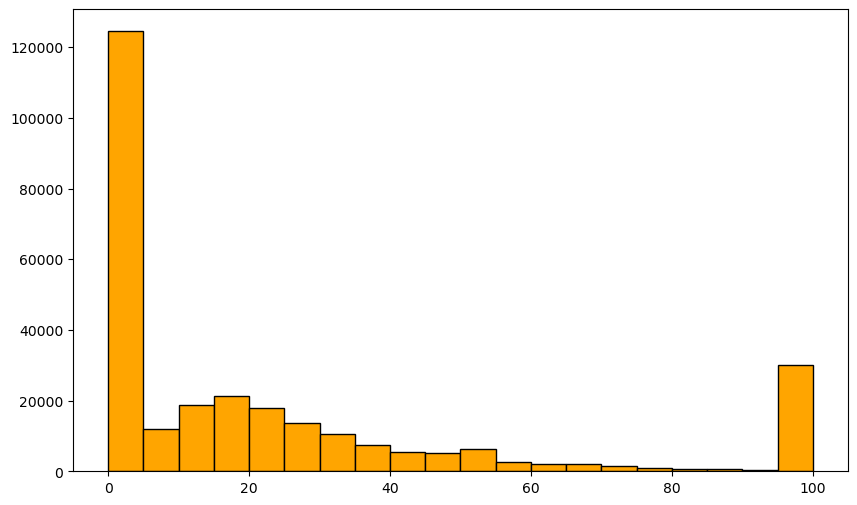

In [38]:
#draw a histogram to see how many stores with different GMV_Cancel_30D_pct
plt.figure(figsize=(10, 6))
plt.hist(store_df_dday['GMV_Cancel_30D_pct'], bins=20, color='orange', edgecolor='black')

In [39]:
#Group by 10-20-30% etc.
pct_group = [0, 10, 20, 30, 40, 50, 80 , 100]

store_df_dday['GMV_Cancel_1D_pct_group'] = pd.cut(store_df_dday['GMV_Cancel_1D_pct'], bins=pct_group, labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-80%', '80-100%'])
store_df_dday['GMV_Cancel_30D_pct_group'] = pd.cut(store_df_dday['GMV_Cancel_30D_pct'], bins=pct_group, labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-80%', '80-100%'])

round(store_df_dday['GMV_Cancel_1D_pct_group'].value_counts()/store_df_dday['GMV_Cancel_1D_pct_group'].value_counts().sum() * 100,1)

GMV_Cancel_1D_pct_group
10-20%    31.700
0-10%     17.600
20-30%    17.300
80-100%   11.200
30-40%     9.100
50-80%     6.700
40-50%     6.400
Name: count, dtype: float64

In [40]:
round(store_df_dday['GMV_Cancel_30D_pct_group'].value_counts()/store_df_dday['GMV_Cancel_30D_pct_group'].value_counts().sum() * 100,1)

GMV_Cancel_30D_pct_group
10-20%    24.600
20-30%    19.400
80-100%   19.300
30-40%    11.100
0-10%      9.500
50-80%     8.600
40-50%     7.500
Name: count, dtype: float64

Interesting!
- After 1 Day, 65% stores have cancellation ratebelow 30%. There always special group with cancellation rate 80%+
- After 30 Days, the cancellation rate increased, Notably 20%% stores have 80%+. Around 47% stores have cancellation rate from 30-80%
---> To make an aggressive control, I propose we set **Stores with Cancellation rate 30%+** after 30 Days should be Warning!

Second Assumption: Lets Take Cancellation **from 30%+ after 30D as Alarming Rate!**

# 3-Data Transformation

In [41]:
#Now We need to transform the data to fit for training model
ecom_df.head()

,date,productid,productname,storecode,storename,first_cat,second_cat,third_cat,industry,have_accountmanager,avg_item_price,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D
0,2020-11-11,"1,730,000,000,000,000,000.000",BĂNG ĐÔ rửa mặt phong cách hàn quốc dễ thương,VNLC3FWH8X,Tiip Gia Dụng,Fashion Accessories,Hair Accessories,Headbands,Fashion,0,0.750,1.503,1.503,0.000,0.000,1.503,0.000,0.000,0.000
1,2020-11-11,"1,730,000,000,000,000,000.000",Bổ Sung Vitamin Germomvit Khoáng Chất Cho Bà...,VNLCNYWLH4,Ba Nấm,Health,Food Supplements,Wellness Supplements,Personal Care & Health,1,11.640,23.285,11.068,12.218,0.000,23.285,0.000,0.000,0.000
2,2020-11-11,"1,730,000,000,000,000,000.000","CINE SET: bộ áo, váy thiết kế Charm By Tea.",VNLCKTWLY7,Charmbytea,Womenswear & Underwear,Women's Suits & Overalls,Sets,Fashion,1,16.330,16.329,16.329,0.000,0.000,0.000,16.329,0.000,0.000
3,2020-11-11,"1,730,000,000,000,000,000.000",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.340,30.678,0.000,0.000,30.678,0.000,0.000,0.000,0.000
4,2020-11-11,"1,730,000,000,000,000,000.000",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.560,15.565,0.000,0.000,0.000,15.565,0.000,15.565,15.565


In [42]:
ecom_df['date'] = pd.to_datetime(ecom_df['date'])

In [43]:
ecom_df['date'].dt.month.value_counts()

date
12    1119094
11     419348
9      417909
8      241531
10     226662
Name: count, dtype: int64

- Around 1.1M (46%) rows for December, and 1.3M (54%) rows from Aug to Nov.
- We may need to divide Dec to get smaller set of data, so Train 70%, Test 30%

In [44]:
ecom_df[ecom_df['date'].dt.month == 12]['date'].dt.day.value_counts()

date
12    515071
6     450620
7      76089
11     21830
10     18849
8      18366
9      18269
Name: count, dtype: int64

I realize we can do like this:
- Train set: Up to 6.12 (72%)
- Test set: From 7 - 12.12 (28%)

We see some steps to do:

- Drop unneeded features and group by: in this model, I want to keep level by date, storecode and first, second, third cat. Avg_Item_price --> I suggest to convert into Total_Items (by GMV / Avg_Item_Price)
- GMV_ features: they should be in % of GMV
- Label Target: store with 30% cancellation rate is high alarmed. We can create a label feature high_cancel_30% - Yes = 1, else 0. From that - see how many High Cancel in each time period ---> To see any imbalance in the dataset
- Train / Test set: do as above
- Category Encoding: industry, first_cate, second_cat, third_cat. Because each row is in product-level. Because these hierachy layers are having highly cardinality, I suggest to do Mean Encoding (which is target the average cancellation rate). The question now is: What to do with the Test data (where in the future, we dont know how much %cancellation rate) - So it is the Data leakage problem. This way, I suggest to put the mean encoding of the training set to the test set

Questions: Should we do Train / Test splitting before Label Target? Should it be any influential between 2 sets
- I dont think so, because we will set High_Cancellation_rate of store level in date level!
- So if Store A in 9.9 have 30% cancellation rate --> Will mark as high. But in 10.10 can be lower
- We will remove date and store feature in the model training. So dont care about specific 1 store

One more thing: to avoid outliers, we can log GMV, but lets see in the model performance first if this step is necessary or not?

## 3-0 Drop unnecessary features and group by - Important Point - Decide how many Features we have (*)

In [45]:
x = ecom_df.copy()
x.head()

,date,productid,productname,storecode,storename,first_cat,second_cat,third_cat,industry,have_accountmanager,avg_item_price,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D
0,2020-11-11,"1,730,000,000,000,000,000.000",BĂNG ĐÔ rửa mặt phong cách hàn quốc dễ thương,VNLC3FWH8X,Tiip Gia Dụng,Fashion Accessories,Hair Accessories,Headbands,Fashion,0,0.750,1.503,1.503,0.000,0.000,1.503,0.000,0.000,0.000
1,2020-11-11,"1,730,000,000,000,000,000.000",Bổ Sung Vitamin Germomvit Khoáng Chất Cho Bà...,VNLCNYWLH4,Ba Nấm,Health,Food Supplements,Wellness Supplements,Personal Care & Health,1,11.640,23.285,11.068,12.218,0.000,23.285,0.000,0.000,0.000
2,2020-11-11,"1,730,000,000,000,000,000.000","CINE SET: bộ áo, váy thiết kế Charm By Tea.",VNLCKTWLY7,Charmbytea,Womenswear & Underwear,Women's Suits & Overalls,Sets,Fashion,1,16.330,16.329,16.329,0.000,0.000,0.000,16.329,0.000,0.000
3,2020-11-11,"1,730,000,000,000,000,000.000",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.340,30.678,0.000,0.000,30.678,0.000,0.000,0.000,0.000
4,2020-11-11,"1,730,000,000,000,000,000.000",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.560,15.565,0.000,0.000,0.000,15.565,0.000,15.565,15.565


In [46]:
#calculate total_items
x['total_items'] = x['GMV'] / x['avg_item_price']

In [47]:
x.columns

Index(['date', 'productid', 'productname', 'storecode', 'storename',
       'first_cat', 'second_cat', 'third_cat', 'industry',
       'have_accountmanager', 'avg_item_price', 'GMV', 'GMV_marketplace',
       'GMV_affiliate', 'GMV_live', 'GMV_product_card', 'GMV_video',
       'GMV_Cancel_1D', 'GMV_Cancel_30D', 'total_items'],
      dtype='object')

Now we need to think about how many features should we encode, so we will group by:

In [48]:
x['first_cat'].nunique()

27

In [49]:
x['second_cat'].nunique()

194

In [50]:
x['third_cat'].nunique()

1410

We have even up to 193 Second_Cat. So we have 2 choices:
- Run up to 27 First Cat only
- Or run up to 193 Second Cat - I wonder if this will be overfit the model?
---> Lets take a safe choice first - 27 First Cat only!

In [51]:
#Group by
cat_col = ['date', 'storecode',
       'first_cat', 'industry', 'second_cat', 'third_cat',
       'have_accountmanager'] #We wont take 'second_cat', 'third_cat', as so many of them

num_col = ['GMV', 'GMV_marketplace',
       'GMV_affiliate', 'GMV_live', 'GMV_product_card', 'GMV_video',
       'GMV_Cancel_1D', 'GMV_Cancel_30D', 'total_items']

# Create a dictionary where keys are numerical columns and the value is 'sum'
agg_dict = {col: 'sum' for col in num_col}

x = x.groupby(cat_col).agg(agg_dict).reset_index() # Use the dictionary in agg
x.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D,total_items
0,2020-08-08,VNLC22LLGV,Food & Beverages,Grocery,Instant Food,"Canned, Jarred & Packaged Foods",0,8.085,0.000,0.000,3.434,2.899,1.753,0.000,0.000,0.999
1,2020-08-08,VNLC22LLMW,Tools & Hardware,Home & Living,Hardware,"Ropes, Chains & Pulleys",0,21.529,12.260,9.269,0.000,14.146,7.383,0.000,0.000,4.002
2,2020-08-08,VNLC22LLUM,Menswear & Underwear,Fashion,Men's Sleepwear & Loungewear,Pajamas,1,23.215,0.000,0.000,0.000,14.199,9.016,0.000,23.215,2.000
3,2020-08-08,VNLC22LLUN,Fashion Accessories,Fashion,Clothes Accessories,Gloves,0,7.652,2.870,2.870,0.000,0.000,7.652,0.000,0.000,5.978
4,2020-08-08,VNLC22LLUN,Menswear & Underwear,Fashion,Men's Underwear,Socks,0,11.199,0.000,5.932,0.071,7.332,3.796,5.266,5.266,2.000


In [52]:
len(ecom_df)

2424544

In [53]:
len(x)

732693

We save a lot of data from group by store level, not product level - from 2.4M to 450k Rows!

## 3-1 Target Label

In [54]:
#We need from the store_df dataset, label them then map back to the ecom_df
high_cancel = 30
store_df['high_cancel_30%'] = store_df['GMV_Cancel_30D_pct'].apply(lambda x: 1 if x >= high_cancel else 0)
store_df.head()

,date,storecode,GMV,GMV_Cancel_1D,GMV_Cancel_30D,GMV_Cancel_1D_pct,GMV_Cancel_30D_pct,high_cancel_30%
0,2020-08-08,VNLC22LLGV,8.085,0.000,0.000,0.000,0.000,0
1,2020-08-08,VNLC22LLMW,21.529,0.000,0.000,0.000,0.000,0
2,2020-08-08,VNLC22LLUM,23.215,0.000,23.215,0.000,100.000,1
3,2020-08-08,VNLC22LLUN,54.578,10.217,10.217,18.720,18.720,0
4,2020-08-08,VNLC22W2TC,2.925,0.000,2.925,0.000,100.000,1


In [55]:
x['date'] = pd.to_datetime(x['date'])
store_df['date'] = pd.to_datetime(store_df['date'])

In [56]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732693 entries, 0 to 732692
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 732693 non-null  datetime64[ns]
 1   storecode            732693 non-null  object        
 2   first_cat            732693 non-null  object        
 3   industry             732693 non-null  object        
 4   second_cat           732693 non-null  object        
 5   third_cat            732693 non-null  object        
 6   have_accountmanager  732693 non-null  int64         
 7   GMV                  732693 non-null  float64       
 8   GMV_marketplace      732693 non-null  float64       
 9   GMV_affiliate        732693 non-null  float64       
 10  GMV_live             732693 non-null  float64       
 11  GMV_product_card     732693 non-null  float64       
 12  GMV_video            732693 non-null  float64       
 13  GMV_Cancel_1D 

In [57]:
#now lets do the mapping with ecom_df - join by date and storecode
merge_x = x.merge(store_df[['date', 'storecode', 'high_cancel_30%']], on=['date', 'storecode'], how='left')
merge_x.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D,total_items,high_cancel_30%
0,2020-08-08,VNLC22LLGV,Food & Beverages,Grocery,Instant Food,"Canned, Jarred & Packaged Foods",0,8.085,0.000,0.000,3.434,2.899,1.753,0.000,0.000,0.999,0
1,2020-08-08,VNLC22LLMW,Tools & Hardware,Home & Living,Hardware,"Ropes, Chains & Pulleys",0,21.529,12.260,9.269,0.000,14.146,7.383,0.000,0.000,4.002,0
2,2020-08-08,VNLC22LLUM,Menswear & Underwear,Fashion,Men's Sleepwear & Loungewear,Pajamas,1,23.215,0.000,0.000,0.000,14.199,9.016,0.000,23.215,2.000,1
3,2020-08-08,VNLC22LLUN,Fashion Accessories,Fashion,Clothes Accessories,Gloves,0,7.652,2.870,2.870,0.000,0.000,7.652,0.000,0.000,5.978,0
4,2020-08-08,VNLC22LLUN,Menswear & Underwear,Fashion,Men's Underwear,Socks,0,11.199,0.000,5.932,0.071,7.332,3.796,5.266,5.266,2.000,0


In [58]:
merge_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732693 entries, 0 to 732692
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 732693 non-null  datetime64[ns]
 1   storecode            732693 non-null  object        
 2   first_cat            732693 non-null  object        
 3   industry             732693 non-null  object        
 4   second_cat           732693 non-null  object        
 5   third_cat            732693 non-null  object        
 6   have_accountmanager  732693 non-null  int64         
 7   GMV                  732693 non-null  float64       
 8   GMV_marketplace      732693 non-null  float64       
 9   GMV_affiliate        732693 non-null  float64       
 10  GMV_live             732693 non-null  float64       
 11  GMV_product_card     732693 non-null  float64       
 12  GMV_video            732693 non-null  float64       
 13  GMV_Cancel_1D 

In [59]:
#Now lets see how many high_cancel_30% group by month
merge_x.groupby(merge_x['date'])['high_cancel_30%'].value_counts()

date        high_cancel_30%
2020-08-08  0                   42910
            1                   13749
2020-09-01  0                    1240
            1                     904
2020-09-02  0                    1223
                                ...  
2020-12-10  1                    2468
2020-12-11  0                    4930
            1                    2706
2020-12-12  0                  118047
            1                   33726
Name: count, Length: 78, dtype: int64

- So high cancellation events contribute 20% in each D-Day campaign - I see that is a proper point from business side
- We can keep like that for train and test set. No need to do any upsampling method

## 3-2 Now let's create Train & Test set

In [60]:
#create the train & test set first, before doing the label encoding
train = merge_x[merge_x['date'] <= '2020-12-06']
test = merge_x[merge_x['date'] > '2020-12-06']
train.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D,total_items,high_cancel_30%
0,2020-08-08,VNLC22LLGV,Food & Beverages,Grocery,Instant Food,"Canned, Jarred & Packaged Foods",0,8.085,0.000,0.000,3.434,2.899,1.753,0.000,0.000,0.999,0
1,2020-08-08,VNLC22LLMW,Tools & Hardware,Home & Living,Hardware,"Ropes, Chains & Pulleys",0,21.529,12.260,9.269,0.000,14.146,7.383,0.000,0.000,4.002,0
2,2020-08-08,VNLC22LLUM,Menswear & Underwear,Fashion,Men's Sleepwear & Loungewear,Pajamas,1,23.215,0.000,0.000,0.000,14.199,9.016,0.000,23.215,2.000,1
3,2020-08-08,VNLC22LLUN,Fashion Accessories,Fashion,Clothes Accessories,Gloves,0,7.652,2.870,2.870,0.000,0.000,7.652,0.000,0.000,5.978,0
4,2020-08-08,VNLC22LLUN,Menswear & Underwear,Fashion,Men's Underwear,Socks,0,11.199,0.000,5.932,0.071,7.332,3.796,5.266,5.266,2.000,0


In [61]:
X = merge_x.drop(['GMV_Cancel_30D', 'high_cancel_30%'], axis=1)
y = merge_x[['date', 'high_cancel_30%']]

In [ ]:
#Save all original data before encoding
train_origin = train.copy()
test_origin = test.copy()

## 3-3 Category encoding

### 3-3-1 Calculate %cancel_30D by different categories

In [63]:
#Now lets calculate value GMV_Cancellation_30D by industry, first_cat... third_cat
industry_cancel_30D = train.groupby('industry')['GMV_Cancel_30D'].sum() / train.groupby('industry')['GMV'].sum()
industry_cancel_30D.head()

industry
Beauty          0.257
Electronics     0.310
Fashion         0.269
Grocery         0.203
Home & Living   0.252
dtype: float64

In [64]:
#Do the same with other layers
first_cat_cancel_30D = train.groupby('first_cat')['GMV_Cancel_30D'].sum() / train.groupby('first_cat')['GMV'].sum()
second_cat_cancel_30D = train.groupby('second_cat')['GMV_Cancel_30D'].sum() / train.groupby('second_cat')['GMV'].sum()
third_cat_cancel_30D = train.groupby('third_cat')['GMV_Cancel_30D'].sum() / train.groupby('third_cat')['GMV'].sum()
third_cat_cancel_30D.head(30)

third_cat
 Backpacks                        0.000
(null)                            0.000
3D Printing Supplies              0.083
AV Receivers                      0.213
Ab Training                       0.155
Abrasive & Finishing Products     0.183
Accessories                       0.257
Accounting Supplies               0.272
Acne Treatments                   0.209
Action & Toy Figures              0.286
Action Cameras                    0.420
Activity Books                    0.128
Acupuncture                       0.155
Adhesives, Tapes & Sealers        0.163
Adult Diapers                     0.154
Agriculture, Forestry & Fishery   0.124
Air Compressors                   0.214
Air Conditioner                   0.551
Air Purifiers                     0.336
Airplanes & Helicopters           0.285
Alarm Systems & Security          0.319
Amber Jewelry Sets                0.530
Amplifiers & Mixers               0.392
Angle Grinders                    0.270
Animals                       

### 3-3-2 Impute that back to train & test set - categories

In [65]:
train.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D,total_items,high_cancel_30%
0,2020-08-08,VNLC22LLGV,Food & Beverages,Grocery,Instant Food,"Canned, Jarred & Packaged Foods",0,8.085,0.000,0.000,3.434,2.899,1.753,0.000,0.000,0.999,0
1,2020-08-08,VNLC22LLMW,Tools & Hardware,Home & Living,Hardware,"Ropes, Chains & Pulleys",0,21.529,12.260,9.269,0.000,14.146,7.383,0.000,0.000,4.002,0
2,2020-08-08,VNLC22LLUM,Menswear & Underwear,Fashion,Men's Sleepwear & Loungewear,Pajamas,1,23.215,0.000,0.000,0.000,14.199,9.016,0.000,23.215,2.000,1
3,2020-08-08,VNLC22LLUN,Fashion Accessories,Fashion,Clothes Accessories,Gloves,0,7.652,2.870,2.870,0.000,0.000,7.652,0.000,0.000,5.978,0
4,2020-08-08,VNLC22LLUN,Menswear & Underwear,Fashion,Men's Underwear,Socks,0,11.199,0.000,5.932,0.071,7.332,3.796,5.266,5.266,2.000,0


In [66]:
#impute value from industry to train set
train['industry'] = train['industry'].map(industry_cancel_30D)
train.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D,total_items,high_cancel_30%
0,2020-08-08,VNLC22LLGV,Food & Beverages,0.203,Instant Food,"Canned, Jarred & Packaged Foods",0,8.085,0.000,0.000,3.434,2.899,1.753,0.000,0.000,0.999,0
1,2020-08-08,VNLC22LLMW,Tools & Hardware,0.252,Hardware,"Ropes, Chains & Pulleys",0,21.529,12.260,9.269,0.000,14.146,7.383,0.000,0.000,4.002,0
2,2020-08-08,VNLC22LLUM,Menswear & Underwear,0.269,Men's Sleepwear & Loungewear,Pajamas,1,23.215,0.000,0.000,0.000,14.199,9.016,0.000,23.215,2.000,1
3,2020-08-08,VNLC22LLUN,Fashion Accessories,0.269,Clothes Accessories,Gloves,0,7.652,2.870,2.870,0.000,0.000,7.652,0.000,0.000,5.978,0
4,2020-08-08,VNLC22LLUN,Menswear & Underwear,0.269,Men's Underwear,Socks,0,11.199,0.000,5.932,0.071,7.332,3.796,5.266,5.266,2.000,0


In [67]:
#Do with other categories
train['first_cat'] = train['first_cat'].map(first_cat_cancel_30D)
train['second_cat'] = train['second_cat'].map(second_cat_cancel_30D)
train['third_cat'] = train['third_cat'].map(third_cat_cancel_30D)

#Do with test set
test['industry'] = test['industry'].map(industry_cancel_30D)
test['first_cat'] = test['first_cat'].map(first_cat_cancel_30D)
test['second_cat'] = test['second_cat'].map(second_cat_cancel_30D)
test['third_cat'] = test['third_cat'].map(third_cat_cancel_30D)

test.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D,total_items,high_cancel_30%
509416,2020-12-07,VNLC22LLBY,0.204,0.203,0.220,0.203,1,19.093,0.000,19.093,0.000,0.000,19.093,1.854,1.854,9.006,0
509417,2020-12-07,VNLC22LLBY,0.204,0.203,0.220,0.222,1,249.518,111.085,202.393,0.000,249.518,0.000,39.169,44.731,121.835,0
509418,2020-12-07,VNLC22LLMW,0.256,0.252,0.197,0.210,0,48.548,48.548,0.000,0.000,48.548,0.000,0.000,0.000,5.000,0
509419,2020-12-07,VNLC22LLQC,0.225,0.224,0.206,0.205,0,8.842,8.842,0.000,0.000,8.842,0.000,0.000,0.000,2.000,0
509420,2020-12-07,VNLC22LLUN,0.225,0.224,0.206,0.143,0,7.004,2.583,0.000,0.000,7.004,0.000,0.000,0.000,3.006,0


Note: as explained, to prevent data leakage, we use the value from train set, and apply them into the test set for all categories mean encoding

## 3-4 Calculate %GMV or Log GMV (if necessary)

### 3-4-1 Convert GMV to %GMV

In [68]:
train.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D,total_items,high_cancel_30%
0,2020-08-08,VNLC22LLGV,0.204,0.203,0.222,0.212,0,8.085,0.000,0.000,3.434,2.899,1.753,0.000,0.000,0.999,0
1,2020-08-08,VNLC22LLMW,0.256,0.252,0.197,0.210,0,21.529,12.260,9.269,0.000,14.146,7.383,0.000,0.000,4.002,0
2,2020-08-08,VNLC22LLUM,0.263,0.269,0.179,0.192,1,23.215,0.000,0.000,0.000,14.199,9.016,0.000,23.215,2.000,1
3,2020-08-08,VNLC22LLUN,0.326,0.269,0.198,0.167,0,7.652,2.870,2.870,0.000,0.000,7.652,0.000,0.000,5.978,0
4,2020-08-08,VNLC22LLUN,0.263,0.269,0.153,0.146,0,11.199,0.000,5.932,0.071,7.332,3.796,5.266,5.266,2.000,0


In [69]:
train.columns

Index(['date', 'storecode', 'first_cat', 'industry', 'second_cat', 'third_cat',
       'have_accountmanager', 'GMV', 'GMV_marketplace', 'GMV_affiliate',
       'GMV_live', 'GMV_product_card', 'GMV_video', 'GMV_Cancel_1D',
       'GMV_Cancel_30D', 'total_items', 'high_cancel_30%'],
      dtype='object')

In [70]:
#Now lets do 2 steps: Group by level, then calculate the percentage and avg_item_price

def feature_engineer(x):
    cat_col = ['date', 'storecode', 'first_cat', 'industry', 'second_cat', 'third_cat', 'have_accountmanager', 'high_cancel_30%']
    num_col = ['GMV', 'GMV_marketplace', 'GMV_affiliate',
       'GMV_live', 'GMV_product_card', 'GMV_video', 'GMV_Cancel_1D',
       'GMV_Cancel_30D', 'total_items']
    
    x = x.groupby(cat_col)[num_col].sum()

    #Calculate %GMV

    x['%GMV_marketplace'] = x['GMV_marketplace'] / x['GMV'] 
    x['%GMV_affiliate'] = x['GMV_affiliate'] / x['GMV']
    x['%GMV_live'] = x['GMV_live'] / x['GMV']  
    x['%GMV_product_card'] = x['GMV_product_card'] / x['GMV']  
    x['%GMV_video'] = x['GMV_video'] / x['GMV']  
    x['%GMV_Cancel_1D'] = x['GMV_Cancel_1D'] / x['GMV']  
    x['%GMV_Cancel_30D'] = x['GMV_Cancel_30D'] / x['GMV']

    #Calculate avg_item_price

    x['avg_item_price'] = x['GMV'] / x['total_items']

    #fillna

    x.fillna(0, inplace=True)


    #Drop all unnecessary columns

    x.drop(columns=['GMV_marketplace', 'GMV_affiliate',
       'GMV_live', 'GMV_product_card', 'GMV_video', 'GMV_Cancel_1D',
       'GMV_Cancel_30D', 'total_items'], inplace=True)
    
    #Reset index

    x.reset_index(inplace=True)

    return x

z = feature_engineer(train)
z.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,high_cancel_30%,GMV,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,%GMV_Cancel_30D,avg_item_price
0,2020-08-08,VNLC22LLGV,0.204,0.203,0.222,0.212,0,0,8.085,0.000,0.000,0.425,0.359,0.217,0.000,0.000,8.090
1,2020-08-08,VNLC22LLMW,0.256,0.252,0.197,0.210,0,0,21.529,0.569,0.431,0.000,0.657,0.343,0.000,0.000,5.380
2,2020-08-08,VNLC22LLUM,0.263,0.269,0.179,0.192,1,1,23.215,0.000,0.000,0.000,0.612,0.388,0.000,1.000,11.610
3,2020-08-08,VNLC22LLUN,0.253,0.269,0.150,0.146,0,0,35.727,0.489,0.000,0.007,0.907,0.086,0.139,0.139,2.382
4,2020-08-08,VNLC22LLUN,0.263,0.269,0.153,0.146,0,0,11.199,0.000,0.530,0.006,0.655,0.339,0.470,0.470,5.600


In [71]:
z.isnull().sum()

date                   0
storecode              0
first_cat              0
industry               0
second_cat             0
third_cat              0
have_accountmanager    0
high_cancel_30%        0
GMV                    0
%GMV_marketplace       0
%GMV_affiliate         0
%GMV_live              0
%GMV_product_card      0
%GMV_video             0
%GMV_Cancel_1D         0
%GMV_Cancel_30D        0
avg_item_price         0
dtype: int64

In [72]:
#Good enough! Now lets apply to train and test set
train = feature_engineer(train)
test = feature_engineer(test)

In [73]:
#Apply for train_origin and test_origin as well
train_origin = feature_engineer(train_origin)
test_origin = feature_engineer(test_origin)

### 3-4-2 Log GMV for less outlier

In [74]:
train.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,high_cancel_30%,GMV,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,%GMV_Cancel_30D,avg_item_price
0,2020-08-08,VNLC22LLGV,0.204,0.203,0.222,0.212,0,0,8.085,0.000,0.000,0.425,0.359,0.217,0.000,0.000,8.090
1,2020-08-08,VNLC22LLMW,0.256,0.252,0.197,0.210,0,0,21.529,0.569,0.431,0.000,0.657,0.343,0.000,0.000,5.380
2,2020-08-08,VNLC22LLUM,0.263,0.269,0.179,0.192,1,1,23.215,0.000,0.000,0.000,0.612,0.388,0.000,1.000,11.610
3,2020-08-08,VNLC22LLUN,0.253,0.269,0.150,0.146,0,0,35.727,0.489,0.000,0.007,0.907,0.086,0.139,0.139,2.382
4,2020-08-08,VNLC22LLUN,0.263,0.269,0.153,0.146,0,0,11.199,0.000,0.530,0.006,0.655,0.339,0.470,0.470,5.600


In [75]:
#log GMV

train['Log_GMV'] = np.log(train['GMV'])
test['Log_GMV'] = np.log(test['GMV'])

#log avg_item_price
train['log_avg_item_price'] = np.log(train['avg_item_price'])
test['log_avg_item_price'] = np.log(test['avg_item_price'])

## 3-5 Correlation

In [76]:
train_corr = train.drop(columns =  ['date', 'storecode'])

In [77]:
corr_matrix = train_corr.corr()

In [78]:
corr_matrix['high_cancel_30%'].sort_values(ascending=False)

high_cancel_30%        1.000
%GMV_Cancel_30D        0.552
%GMV_Cancel_1D         0.410
third_cat              0.142
second_cat             0.129
log_avg_item_price     0.115
first_cat              0.097
industry               0.088
avg_item_price         0.088
%GMV_live              0.043
Log_GMV                0.036
%GMV_affiliate         0.035
GMV                    0.011
%GMV_marketplace       0.011
%GMV_product_card     -0.012
%GMV_video            -0.032
have_accountmanager   -0.072
Name: high_cancel_30%, dtype: float64

## 3-6 Split x, y train & test

In [79]:
test.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,high_cancel_30%,GMV,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,%GMV_Cancel_30D,avg_item_price,Log_GMV,log_avg_item_price
0,2020-12-07,VNLC22LLBY,0.204,0.203,0.220,0.203,1,0,19.093,0.000,1.000,0.000,0.000,1.000,0.097,0.097,2.120,2.949,0.751
1,2020-12-07,VNLC22LLBY,0.204,0.203,0.220,0.222,1,0,249.518,0.445,0.811,0.000,1.000,0.000,0.157,0.179,2.048,5.520,0.717
2,2020-12-07,VNLC22LLMW,0.256,0.252,0.197,0.210,0,0,48.548,1.000,0.000,0.000,1.000,0.000,0.000,0.000,9.710,3.883,2.273
3,2020-12-07,VNLC22LLQC,0.225,0.224,0.206,0.205,0,0,8.842,1.000,0.000,0.000,1.000,0.000,0.000,0.000,4.420,2.179,1.486
4,2020-12-07,VNLC22LLUN,0.198,0.224,0.190,0.146,0,0,3.697,1.000,0.000,0.000,1.000,0.000,0.500,0.500,1.850,1.307,0.615


In [80]:
X_train = train.drop(columns=['date', 'storecode', '%GMV_Cancel_30D', 'high_cancel_30%', 'GMV', 'avg_item_price'])
y_train = train[['high_cancel_30%']]

X_test = test.drop(columns=['date', 'storecode', '%GMV_Cancel_30D', 'high_cancel_30%', 'GMV', 'avg_item_price'])
y_test = test[['high_cancel_30%']]
X_test.head()

#Note: pls dont include %GMV_30D - it could create data leakage

,first_cat,industry,second_cat,third_cat,have_accountmanager,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,Log_GMV,log_avg_item_price
0,0.204,0.203,0.220,0.203,1,0.000,1.000,0.000,0.000,1.000,0.097,2.949,0.751
1,0.204,0.203,0.220,0.222,1,0.445,0.811,0.000,1.000,0.000,0.157,5.520,0.717
2,0.256,0.252,0.197,0.210,0,1.000,0.000,0.000,1.000,0.000,0.000,3.883,2.273
3,0.225,0.224,0.206,0.205,0,1.000,0.000,0.000,1.000,0.000,0.000,2.179,1.486
4,0.198,0.224,0.190,0.146,0,1.000,0.000,0.000,1.000,0.000,0.500,1.307,0.615


In [81]:
# There is Find rows that contain any infinite values
infinite_rows_train = X_train[np.isinf(X_train).any(axis=1)]

# Display the rows with infinite values
infinite_rows_train.head(100)

,first_cat,industry,second_cat,third_cat,have_accountmanager,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,Log_GMV,log_avg_item_price
16,0.256,0.252,0.197,0.220,1,1.000,1.000,0.210,0.651,0.139,0.667,-8.979,-inf
166,0.225,0.224,0.235,0.251,1,0.204,0.480,0.184,0.608,0.208,0.093,6.344,-inf
186,0.316,0.310,0.416,0.281,1,0.553,0.000,0.519,0.308,0.174,0.000,-2.444,-inf
364,0.285,0.252,0.297,0.300,0,0.000,0.000,0.211,0.624,0.165,0.000,1.015,-inf
388,0.303,0.224,0.250,0.286,0,0.000,0.000,0.607,0.393,0.000,0.000,3.738,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6661,0.204,0.203,0.222,0.174,0,1.000,0.000,0.390,0.512,0.098,0.000,-10.078,-inf
6707,0.343,0.269,0.300,0.177,1,0.269,0.630,0.060,0.454,0.485,0.069,5.413,-inf
6828,0.235,0.257,0.303,0.283,1,0.000,0.000,0.000,0.000,0.000,0.000,-inf,-inf
6830,0.326,0.269,0.407,0.419,0,1.000,0.000,0.000,1.000,0.000,0.000,-10.078,-inf


In [82]:
# There is Find rows that contain any infinite values
infinite_rows_test = X_test[np.isinf(X_test).any(axis=1)]

# Display the rows with infinite values
infinite_rows_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1787 entries, 36 to 223079
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   first_cat            1787 non-null   float64
 1   industry             1787 non-null   float64
 2   second_cat           1787 non-null   float64
 3   third_cat            1787 non-null   float64
 4   have_accountmanager  1787 non-null   int64  
 5   %GMV_marketplace     1787 non-null   float64
 6   %GMV_affiliate       1787 non-null   float64
 7   %GMV_live            1787 non-null   float64
 8   %GMV_product_card    1787 non-null   float64
 9   %GMV_video           1787 non-null   float64
 10  %GMV_Cancel_1D       1787 non-null   float64
 11  Log_GMV              1787 non-null   float64
 12  log_avg_item_price   1787 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 195.5 KB


In [83]:
infinite_rows_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5981 entries, 16 to 509265
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   first_cat            5981 non-null   float64
 1   industry             5981 non-null   float64
 2   second_cat           5981 non-null   float64
 3   third_cat            5981 non-null   float64
 4   have_accountmanager  5981 non-null   int64  
 5   %GMV_marketplace     5981 non-null   float64
 6   %GMV_affiliate       5981 non-null   float64
 7   %GMV_live            5981 non-null   float64
 8   %GMV_product_card    5981 non-null   float64
 9   %GMV_video           5981 non-null   float64
 10  %GMV_Cancel_1D       5981 non-null   float64
 11  Log_GMV              5981 non-null   float64
 12  log_avg_item_price   5981 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 654.2 KB


In [84]:
# Therefore, we need to solve this one, by replace with 0
if np.isinf(X_train.values).any():
    print("Solving inf values in X_train")
    X_train.replace([np.inf, -np.inf], 0, inplace=True)

if np.isinf(X_test.values).any():
    print("Solving inf values in X_test")
    X_test.replace([np.inf, -np.inf], 0, inplace=True)

Solving inf values in X_train
Solving inf values in X_test


# 4-Baseline Model

Now I want to test:
- Decision Tree: lets take that as Baseline Model
- Logistic Regression: may need to do feature scaling
- Random Forest
- XGBoost
- LightGBM
- Do with GridSearchCV Optimization to tuning the parameters

In [85]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

In [86]:
# Initialize and train the decision tree classifier
Dec_Tree = DecisionTreeClassifier(random_state=42)
Dec_Tree.fit(X_train, y_train)

max_depth = Dec_Tree.tree_.max_depth
print("Maximum depth of the decision tree:", max_depth)

num_leaves = Dec_Tree.tree_.n_leaves
print("Number of leaves in the decision tree:", num_leaves)

# Calculate and print the ROC AUC score using the predicted probabilities of the positive class
print(roc_auc_score(y_train, Dec_Tree.predict_proba(X_train)[:, 1]))

y_pred = Dec_Tree.predict(X_test)
y_pred_prob = Dec_Tree.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score on test data:", accuracy)

test_roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC AUC score on test data:", test_roc_auc)

print("Classification report on test data:", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix on test data:" , conf_matrix)

Maximum depth of the decision tree: 66
Number of leaves in the decision tree: 98487
0.9999910004980666
Accuracy score on test data: 0.7303769401330377
ROC AUC score on test data: 0.6404639308687399
Classification report on test data:               precision    recall  f1-score   support

           0       0.83      0.82      0.82    168761
           1       0.45      0.46      0.46     54484

    accuracy                           0.73    223245
   macro avg       0.64      0.64      0.64    223245
weighted avg       0.73      0.73      0.73    223245

Confusion matrix on test data: [[137773  30988]
 [ 29204  25280]]


In [87]:
from sklearn.metrics import precision_recall_curve, auc

# Get probabilities and calculate precision-recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

print(f"Precision-Recall AUC: {pr_auc}")

Precision-Recall AUC: 0.5213899675684447


- Class 0 (Cancellation < 30%): Precision is 0.83, and recall is 0.82, meaning the model effectively captures 83% true instances of class 0.

- Class 1 (High Cancellation 30%+): Precision is 0.45, suggesting that when the model predicts class 1 - only 45% accurate. Recall is only 0.46, meaning the model identifies only 46% of true class 1 cases. The F1-score is very low (0.46), showing poor balance between precision and recall.

- Because it is only 46% Recall in Class 1, while we want to best capture all High Cancellation Stores. Therefore, we need to try other models that best improve the Recall - Or try to upsampling the Class 1 in the Train set

# 5-Upsampling

Just in case we want to choose Upsampling method, to add more rows for the minority Class 1

In [88]:
X_train.head()

,first_cat,industry,second_cat,third_cat,have_accountmanager,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,Log_GMV,log_avg_item_price
0,0.204,0.203,0.222,0.212,0,0.000,0.000,0.425,0.359,0.217,0.000,2.090,2.091
1,0.256,0.252,0.197,0.210,0,0.569,0.431,0.000,0.657,0.343,0.000,3.069,1.683
2,0.263,0.269,0.179,0.192,1,0.000,0.000,0.000,0.612,0.388,0.000,3.145,2.452
3,0.253,0.269,0.150,0.146,0,0.489,0.000,0.007,0.907,0.086,0.139,3.576,0.868
4,0.263,0.269,0.153,0.146,0,0.000,0.530,0.006,0.655,0.339,0.470,2.416,1.723


In [89]:
y_train.head()

,high_cancel_30%
0,0
1,0
2,1
3,0
4,0


In [90]:
y_train.value_counts()/y_train.value_counts().sum() * 100

high_cancel_30%
0                 76.400
1                 23.600
Name: count, dtype: float64

In [91]:
y_test.value_counts()/y_test.value_counts().sum() * 100

high_cancel_30%
0                 75.595
1                 24.405
Name: count, dtype: float64

So we see that only 25% Class 1 in both y_train and y_test. Seems quite worth upsampling Class 1?

In [92]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 6-Model Training

## 6-1 LightGBM

### Baseline LightGBM - with SMOTE only, no tuning

In [ ]:
# Import necessary libraries
!pip install lightgbm

import lightgbm as lgb

In [ ]:
# Define your X_train, X_test, y_train, y_test datasets
# Assuming these are already split

# Step 1: Apply SMOTE to oversample the minority class - Did above in XGBoost

# Step 2: Define the LightGBM model and parameter grid
lgb_model = lgb.LGBMClassifier(objective='binary', random_state=42)

# Fit on the resampled training data
lgb_model.fit(X_train_resampled, y_train_resampled)

# Step 4: Evaluate the model on the test set
y_pred = lgb_model.predict(X_test)
y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]  # Probability predictions for ROC AUC

# Step 5: Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output results
print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

[LightGBM] [Info] Number of positive: 389190, number of negative: 389190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 778380, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy Score: 0.8246052543170059
ROC AUC Score: 0.7900081141784856
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89    168761
           1       0.73      0.45      0.56     54484

    accuracy                           0.82    223245
   macro avg       0.78      0.70      0.72    223245
weighted avg       0.81      0.82      0.81    223245

Confusion Matrix:
 [[159606   9155]
 [ 30001  24483]]


### Now lets tune

I wont use GridSearchCV this time. Its so time-consuming. Lets go with the RandomSearch option

In [ ]:
# Calculate scale_pos_weight based on original training data distribution
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define a smaller, focused parameter grid
param_grid = {
    'max_depth': [6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [scale_pos_weight * 0.5, scale_pos_weight, scale_pos_weight * 2],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    scoring='f1',  # Choose metric based on business needs
    cv=3,
    n_jobs=-1,
    verbose=1,
    n_iter=20,  # Number of random parameter settings to try
    random_state=42
)

# Fit RandomizedSearchCV on the resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Extract the best model
best_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)

# Make predictions and evaluate performance on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability predictions for ROC AUC

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output results
print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 389190, number of negative: 389190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 778380, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best parameters found:  {'subsample': 1.0, 'scale_pos_weight': 1.0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Accuracy Score: 0.8174919931017492
ROC AUC Score: 0.7806896844943163
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.88    168761
           1       0.68      0.47      0.56     54484


### LightGBM Conclusion: All the same pfm. I will pick LightGBM no SMOTE/Tuning, f1-score for Label-1 56% & Accuracy 82%

LightGBM no SMOTE/

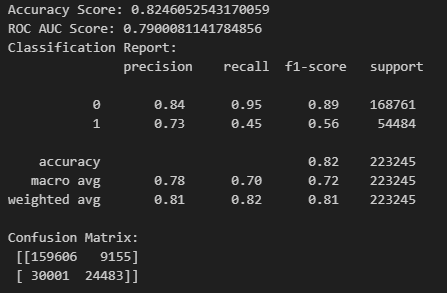

## 6-2 CatBoost

### Baseline CatBoost - without SMOTE or Tuning

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

# Initialize the CatBoost classifier with default parameters
catboost_model = CatBoostClassifier(
    verbose=0,  # Suppress CatBoost output for cleaner logs
    scale_pos_weight=scale_pos_weight  # Set the scale_pos_weight based on original data distribution
)

# Fit the model on the training data (without any SMOTE or tuning)
catboost_model.fit(X_train, y_train)

# Predictions on test data
y_pred = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy Score: 0.8278931219064257
ROC AUC Score: 0.7970012126205176
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.89    168761
           1       0.77      0.42      0.54     54484

    accuracy                           0.83    223245
   macro avg       0.80      0.69      0.72    223245
weighted avg       0.82      0.83      0.81    223245

Confusion Matrix:
 [[161910   6851]
 [ 31571  22913]]


### With Tuning

In [ ]:
# Calculate scale_pos_weight based on the original data distribution
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define the parameter grid for CatBoost
param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [100, 200, 300],
    'scale_pos_weight': [scale_pos_weight * 0.5, scale_pos_weight, scale_pos_weight * 3],
    'l2_leaf_reg': [3, 5, 7],
    'bagging_temperature': [0, 1, 2]
}

# Initialize the CatBoost classifier
catboost_model = CatBoostClassifier(verbose=0)  # verbose=0 suppresses CatBoost output for a cleaner log

# Initialize RandomizedSearchCV with f1 score (focusing on the minority class)
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    scoring=make_scorer(f1_score, pos_label=1),
    cv=3,
    n_jobs=-1,
    verbose=1,
    n_iter=15,  # Limiting to a reasonable number of combinations for efficiency
    random_state=42
)

# Perform RandomizedSearchCV
random_search.fit(X_train, y_train)

# Extract the best model from RandomizedSearchCV
best_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)

# Predictions on test data
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters found:  {'scale_pos_weight': 3.0, 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 100, 'depth': 6, 'bagging_temperature': 2}
Accuracy Score: 0.803328182042151
ROC AUC Score: 0.782003838825267
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87    168761
           1       0.62      0.52      0.56     54484

    accuracy                           0.80    223245
   macro avg       0.73      0.71      0.72    223245
weighted avg       0.79      0.80      0.80    223245

Confusion Matrix:
 [[151181  17580]
 [ 26326  28158]]


### With SMOTE

In [ ]:
# Initialize the CatBoost classifier with default parameters
catboost_model = CatBoostClassifier(
    verbose=0,  # Suppress CatBoost output for cleaner logs
    scale_pos_weight=scale_pos_weight  # Set the scale_pos_weight based on original data distribution
)

# Fit the model on the training data (without any SMOTE or tuning)
catboost_model.fit(X_train_resampled, y_train_resampled)

# Predictions on test data
y_pred = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)


Accuracy Score: 0.8273824721718291
ROC AUC Score: 0.7952211878560947
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.89    168761
           1       0.76      0.43      0.55     54484

    accuracy                           0.83    223245
   macro avg       0.80      0.69      0.72    223245
weighted avg       0.82      0.83      0.81    223245

Confusion Matrix:
 [[161180   7581]
 [ 30955  23529]]


### With SMOTE + Tune

In [ ]:
# Define an adjusted parameter grid for CatBoost tuning
param_grid = {
    'iterations': [200, 300, 400],  # Increasing iterations
    'learning_rate': [0.05, 0.1],   # Higher learning rate options
    'depth': [4, 6, 8],             # Broader depth range
    'l2_leaf_reg': [3, 5, 7]        # Regularization range
}

# Initialize the CatBoost classifier without scale_pos_weight
catboost_model = CatBoostClassifier(
    verbose=0,         # Suppress training logs
    random_seed=42
)

# Use RandomizedSearchCV with balanced accuracy for a more balanced approach
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1,
    n_iter=15,   # Testing 15 random combinations
    random_state=42
)

# Fit the model with RandomizedSearchCV
random_search.fit(X_train_resampled, y_train_resampled)

# Evaluate the best model on the test data
best_model = random_search.best_estimator_

# Predictions on the test data
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best parameters found: ", random_search.best_params_)
print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters found:  {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 4}
Accuracy Score: 0.8220699231785706
ROC AUC Score: 0.7874167884253556
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89    168761
           1       0.71      0.45      0.55     54484

    accuracy                           0.82    223245
   macro avg       0.78      0.70      0.72    223245
weighted avg       0.81      0.82      0.81    223245

Confusion Matrix:
 [[158787   9974]
 [ 29748  24736]]


### CatBoost Conclusion: Baseline, SMOTE or Tuning does not help improve f1-score Label-1 much, keep the same 55% in all sets. I would prefer CatBoost No SMOTE/Tune with 56% f1-score Label-1 with Accuracy 82%

CatBoost No SMOTE/Tune

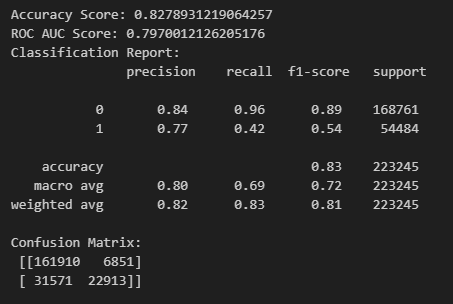

## 6-3 Random Forest

### Baseline Random Forest - No Tuning, No SMOTE

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,  # You can adjust this number if needed
    max_depth=None,     # No restriction on depth
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True
)

# Fit the model on the training data (no SMOTE, no tuning)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability predictions for ROC AUC

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy Score: 0.8104683195592286
ROC AUC Score: 0.7657129352400623
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.88    168761
           1       0.67      0.44      0.53     54484

    accuracy                           0.81    223245
   macro avg       0.75      0.69      0.71    223245
weighted avg       0.80      0.81      0.80    223245

Confusion Matrix:
 [[156963  11798]
 [ 30514  23970]]


### With SMOTE

In [ ]:
# Fit the model on the resampled training data
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability predictions for ROC AUC

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy Score: 0.8040941566440458
ROC AUC Score: 0.7620040688994295
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.88    168761
           1       0.63      0.48      0.54     54484

    accuracy                           0.80    223245
   macro avg       0.74      0.69      0.71    223245
weighted avg       0.79      0.80      0.79    223245

Confusion Matrix:
 [[153494  15267]
 [ 28468  26016]]


### With SMOTE and Tuning

It will take so long to do the tuning. Instead, we do the CV

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=5, scoring='f1')

# Print the cross-validation scores
print("Cross-validation F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())

# Fit the model on the entire resampled training data
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = cv_scores.predict(X_test)
y_pred_proba = cv_scores.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

### RF Conclusion: all the sames. Again I took RF No SMOTE/Tuning

RF No SMOTE/Tuning

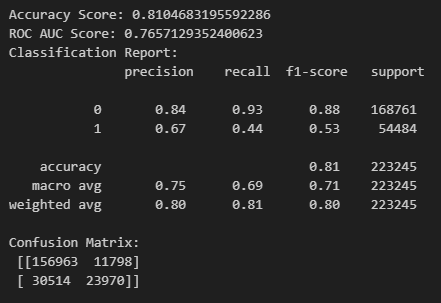

## 6-4 XGBoost

### Baseline XGBoost

In [119]:
!pip install xgboost
import xgboost as xgb

In [120]:
# Initialize the XGBoost model
model_xgb_base = xgb.XGBClassifier(
    max_depth=6,          # Maximum depth of the tree
    learning_rate=0.1,    # Step size shrinkage
    n_estimators=100,     # Number of boosting rounds
    scale_pos_weight=1,   # Handle class imbalance (adjust this if needed)
    use_label_encoder=False,
    eval_metric='logloss' # Avoid warning for label encoding
)

# Train the model
model_xgb_base.fit(X_train, y_train)

# Predictions
y_pred = model_xgb_base.predict(X_test)
y_pred_proba = model_xgb_base.predict_proba(X_test)[:, 1]  # Probability predictions for ROC AUC

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy Score: 0.8276422764227642
ROC AUC Score: 0.7947594523800081
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.89    168761
           1       0.77      0.42      0.54     54484

    accuracy                           0.83    223245
   macro avg       0.80      0.69      0.72    223245
weighted avg       0.82      0.83      0.81    223245

Confusion Matrix:
 [[161741   7020]
 [ 31458  23026]]


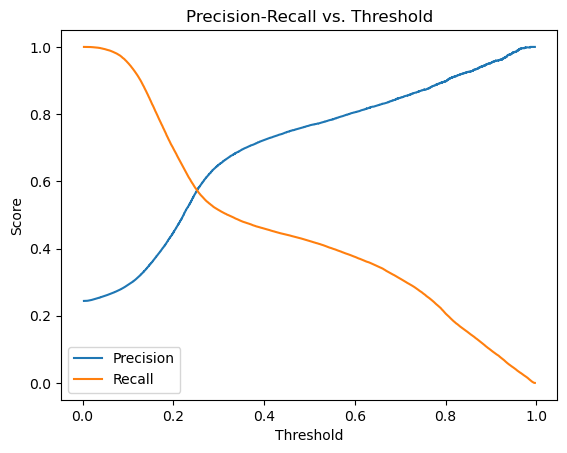

In [121]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot Precision-Recall vs Threshold to choose a balanced threshold
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs. Threshold")
plt.legend()
plt.show()

In [122]:
# Use chosen threshold
optimal_threshold = 0.195  # Adjust based on precision-recall curve, but consider to lower as much as possible - to get more precise Class 1 
y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate with adjusted threshold
accuracy = accuracy_score(y_test, y_pred_adjusted)
class_report = classification_report(y_test, y_pred_adjusted)
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

print(f"Accuracy Score: {accuracy}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy Score: 0.7061837891106184
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.70      0.78    168761
           1       0.44      0.71      0.54     54484

    accuracy                           0.71    223245
   macro avg       0.66      0.71      0.66    223245
weighted avg       0.77      0.71      0.72    223245

Confusion Matrix:
 [[118970  49791]
 [ 15802  38682]]


### With SMOTE

In [326]:
# Calculate scale_pos_weight for the resampled data
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])
scale_pos_weight

1.0

OK, so it is 50-50. Class 0 observations = Class 1

In [327]:
# Train XGBoost with adjusted scale_pos_weight
model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train_resampled, y_train_resampled)


# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability predictions for ROC AUC

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)


Accuracy Score: 0.8234988465587135
ROC AUC Score: 0.7900939575034207
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89    168761
           1       0.71      0.46      0.56     54484

    accuracy                           0.82    223245
   macro avg       0.78      0.70      0.73    223245
weighted avg       0.81      0.82      0.81    223245

Confusion Matrix:
 [[158643  10118]
 [ 29285  25199]]


#### Lets use Threshold to improve the result

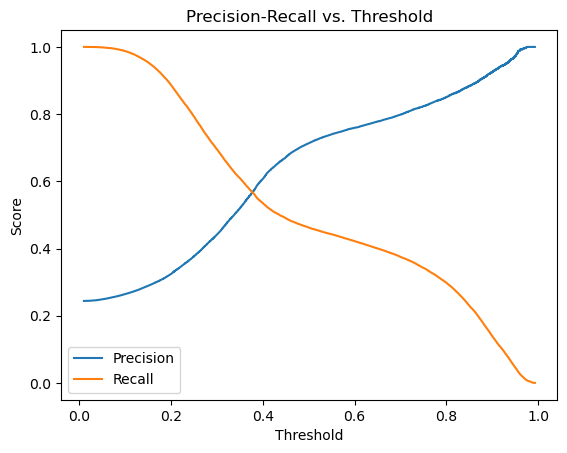

In [328]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot Precision-Recall vs Threshold to choose a balanced threshold
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs. Threshold")
plt.legend()
plt.show()

In [333]:
# Use chosen threshold
optimal_threshold = 0.3  # Adjust based on precision-recall curve, but consider to lower as much as possible - to get more precise Class 1 
y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate with adjusted threshold
accuracy = accuracy_score(y_test, y_pred_adjusted)
class_report = classification_report(y_test, y_pred_adjusted)
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

print(f"Accuracy Score: {accuracy}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy Score: 0.7107303635019822
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.72      0.79    168761
           1       0.44      0.70      0.54     54484

    accuracy                           0.71    223245
   macro avg       0.66      0.71      0.66    223245
weighted avg       0.77      0.71      0.73    223245

Confusion Matrix:
 [[120780  47981]
 [ 16597  37887]]


I tested several threshold, but seems we have lots of trade-off btw Precision and Recall in Class 1. Overall, we need to improve the f1-score. So lets see how to improve the f1-score

### Fine Tune with GridSearch CV and Threshold Precision-Recall

In [ ]:
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Tune parameters
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5],
    'scale_pos_weight': [1]  # Use 1 if SMOTE is applied
}

random_search = RandomizedSearchCV(
    xgb_model,
    param_grid,
    n_iter=20,  # Number of parameter settings sampled
    scoring='f1',  # Focus on F1 score due to class imbalance
    cv=3,  # Cross-validation splitting strategy
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit on resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# After tuning, you can access the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best F1 score: ", random_search.best_score_)

Best parameters found:  {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 1.0}
Best F1 score:  0.7643300946243144


In [ ]:
# Xgb_Tune model
xgb_tune = random_search.best_estimator_

# Predict probabilities
y_pred = xgb_tune.predict(X_test)
y_pred_proba = xgb_tune.predict_proba(X_test)[:, 1]

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy Score: 0.826576183117203
ROC AUC Score: 0.7932424531031916
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89    168761
           1       0.74      0.45      0.56     54484

    accuracy                           0.83    223245
   macro avg       0.79      0.70      0.72    223245
weighted avg       0.82      0.83      0.81    223245

Confusion Matrix:
 [[160228   8533]
 [ 30183  24301]]


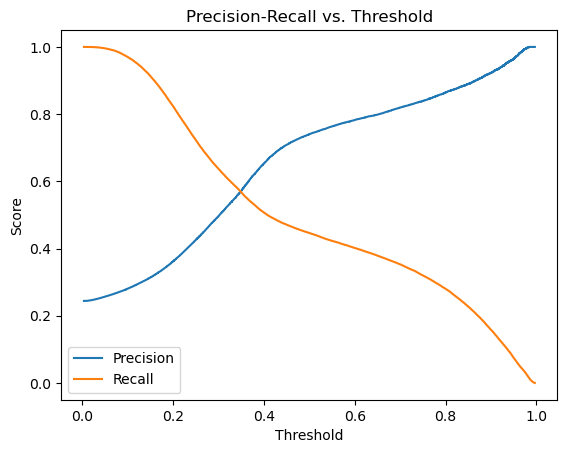

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot Precision-Recall vs Threshold to choose a balanced threshold
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs. Threshold")
plt.legend()
plt.show()

In [ ]:
# Use chosen threshold
optimal_threshold = 0.22  # Adjust based on precision-recall curve, but consider to lower as much as possible - to get more precise Class 1 
y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate with adjusted threshold
accuracy = accuracy_score(y_test, y_pred_adjusted)
class_report = classification_report(y_test, y_pred_adjusted)
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

print(f"Accuracy Score: {accuracy}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy Score: 0.643597840937087
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.60      0.72    168761
           1       0.39      0.78      0.52     54484

    accuracy                           0.64    223245
   macro avg       0.64      0.69      0.62    223245
weighted avg       0.77      0.64      0.67    223245

Confusion Matrix:
 [[101088  67673]
 [ 11892  42592]]


### XGB Conclusion: SMOTE or Tuning dont have more impact. Take XGB No SMOTE/Tuning but choose Precision/Recall Threshold = 0.195 to have better Recall

XGB No SMOTE/Tuning but have Precision/Recal = 0.195

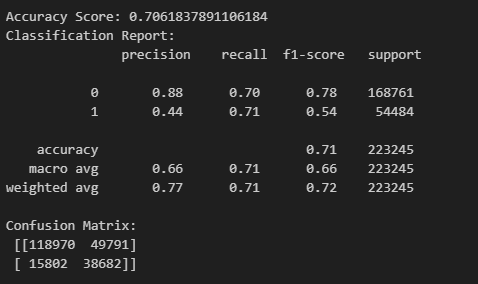

# 7-Model Conclusion, Interpret & Save Model

## 7-1 Conclusion & Interpret

The best performing model: XGB No SMOTE/Tuning but have Precision/Recall Threshold = 0.195

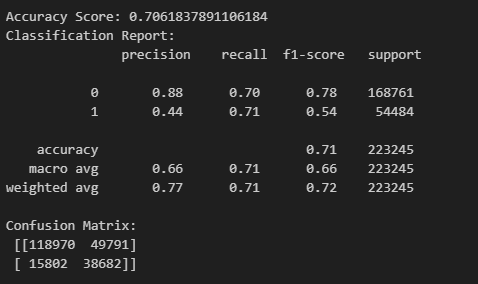

- Seems all the SMOTE or Tuning don't help much to improve our f1-score for Label_1 (High_cancellation_30% = Yes). Because the data is already highly imbalanced, not ez to change
- However, in the problem set, we want to prioritize Recall more than Precision - Detect Highly_Cancelled_30% Stores as MANY as possible.
- With XGB and using Precision/Recall Threshold = 0.195, we have better recall_Label_1 = 71% (while others only 47%), but still keep f1-score = 55% and Accuracy = 73% (Acceptable rate)
- Let's save this model to step 7. Intepretion & Save pkl file for Streamlit App!


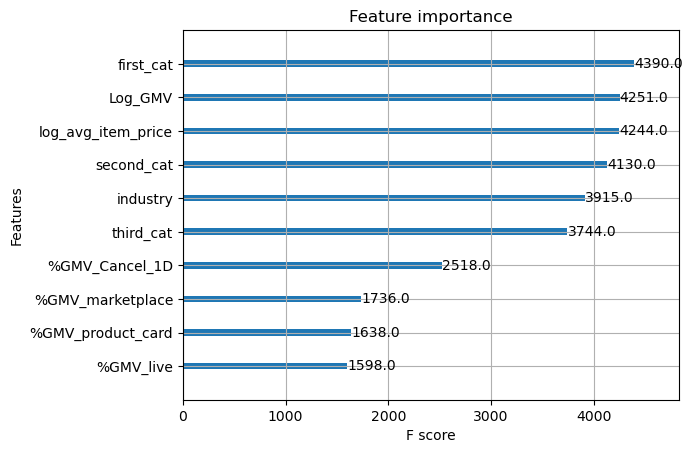

In [ ]:
#feature importance

xgb.plot_importance(xgb_tune, importance_type="weight", max_num_features=10)
plt.show()

Now we see some important features that impact to High Cancellation: first_cat, Log_GMV, log_avg_item_price and second_cat

In [ ]:
# Extract original feature names
feature_names = X_test.columns

# Assign these feature names to X_test
X_test.columns = feature_names
X_test.columns

Index(['first_cat', 'industry', 'second_cat', 'third_cat',
       'have_accountmanager', '%GMV_marketplace', '%GMV_affiliate',
       '%GMV_live', '%GMV_product_card', '%GMV_video', '%GMV_Cancel_1D',
       'Log_GMV', 'log_avg_item_price'],
      dtype='object')

In [ ]:
!pip install shap
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_tune)
# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

   ---------------------------------------- 0.0/456.2 kB ? eta -:--:--
   --- ------------------------------------ 41.0/456.2 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 456.2/456.2 kB 9.5 MB/s eta 0:00:00


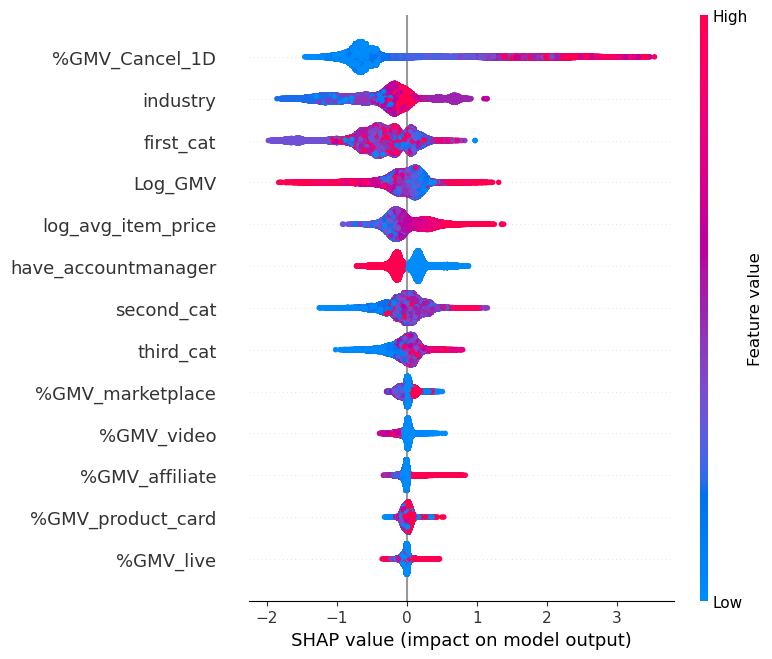

In [ ]:
# Create a SHAP summary plot
shap.summary_plot(shap_values, X_test)

The summary plot shows the feature importance of each feature in the model. 

- The results show that %GMV_Cancel_1D,” “Industry”, 'first_cat' and 'Log_GMV' play major roles in determining the results.
- The more red dots in the positive SHAP value, the higher %cancellation rate in our prediction
- For eg: lets see Log_GMV, we see that most red dots in negative side of SHAP value, so Higher GMV --> Less probability of %Cancellation
- Interesting observation: higher avg_item_price, more likely to have high Cancellation rate? (cause more red dots in the positive side of SHAP value)

Now, I want to test 1 store example that have high cancellation 30%+, and see features that having impact on

In [505]:
y_test[y_test['high_cancel_30%'] == 1]

,high_cancel_30%
10,1
11,1
14,1
15,1
22,1
...,...
223192,1
223195,1
223212,1
223231,1


In [521]:
#Lets take row 14
X_test.iloc[14, :]

first_cat             0.285
industry              0.252
second_cat            0.167
third_cat             0.160
have_accountmanager   0.000
%GMV_marketplace      0.000
%GMV_affiliate        0.000
%GMV_live             1.000
%GMV_product_card     0.000
%GMV_video            0.000
%GMV_Cancel_1D        0.000
Log_GMV               2.486
log_avg_item_price    2.486
Name: 14, dtype: float64

In [ ]:
shap.initjs()
# Pick an instance to explain
instance = 14  # set the 14 instance in X_test

# Generate force plot for a single instance
shap.force_plot(explainer.expected_value, shap_values[instance, :], X_test.iloc[instance, :])

In [520]:
first_cat_cancel_30D.head(50)

first_cat
Automotive & Motorcycle             0.285
Baby & Maternity                    0.225
Beauty & Personal Care              0.235
Books, Magazines & Audio            0.206
Collectibles                        0.243
Computers & Office Equipment        0.284
Fashion Accessories                 0.326
Food & Beverages                    0.204
Furniture                           0.323
Health                              0.237
Home Improvement                    0.237
Home Supplies                       0.189
Household Appliances                0.303
Jewelry Accessories & Derivatives   0.383
Kids' Fashion                       0.198
Kitchenware                         0.260
Luggage & Bags                      0.273
Menswear & Underwear                0.263
Muslim Fashion                      0.105
Pet Supplies                        0.189
Phones & Electronics                0.316
Shoes                               0.244
Sports & Outdoor                    0.343
Textiles & Soft Furnishi

In this example of row 14 with High Cancellation rate 30%, we analyze the impact of each features to the Cancellation
- log_avg_item_price seems to have the highest impact on Cancellation
- Next, the store does not have account manager (accountmanager = 0) also have lots impact on high cancellation
- We identify that first cat is Automotive & Motorcycle. So maybe this store without Account Manager - and high-priced items like Automotive - is more likely to have high cancellation
- Other features have light impact on this store cancellation

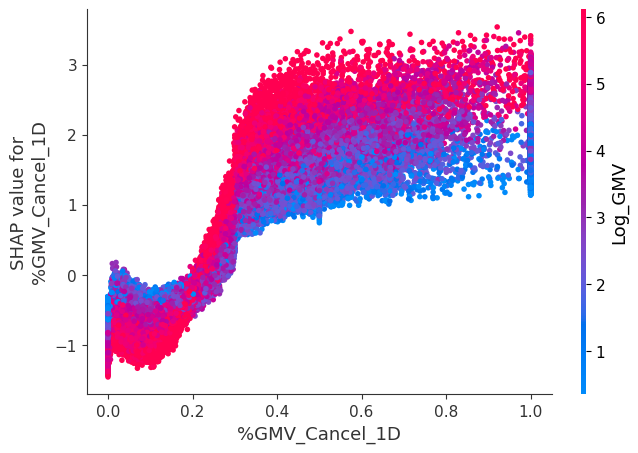

In [300]:
# SHAP dependence plot for a specific feature
shap.dependence_plot("%GMV_Cancel_1D", shap_values, X_test)

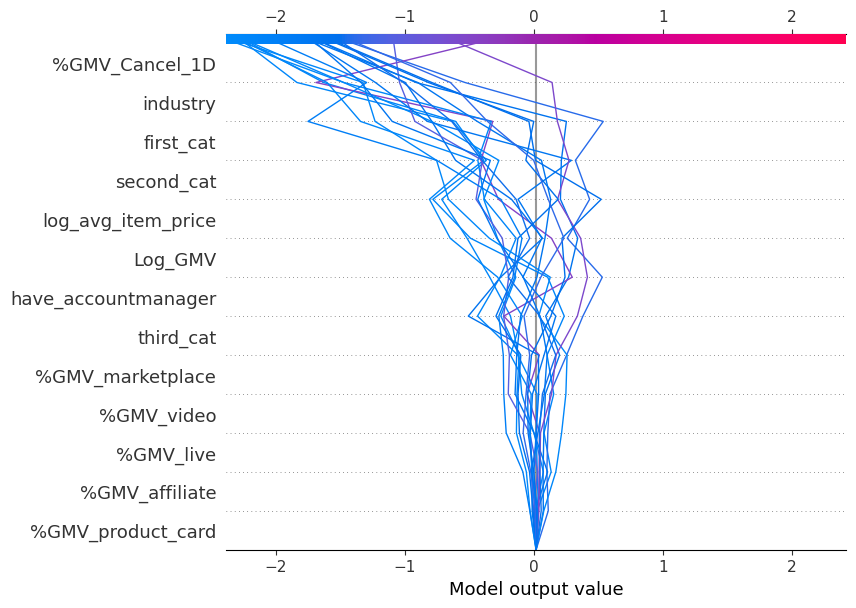

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values[:20], X_test.iloc[:20])  # Analyzes the first 20 instances

## 7-2 Save Model

In [126]:
import joblib

# Define the path where you want to save the model
file_path = 'C:/Users/a00578421/Downloads/Project/predict/xgb_model.pkl'  # Replace with the desired directory and filename

# Save the trained model as a .pkl file locally
joblib.dump(model_xgb_base, file_path)

# Confirm the model is saved
print(f"Model saved to {file_path}")

# You can load the model later using:
# loaded_model = joblib.load(file_path)

Model saved to C:/Users/a00578421/Downloads/Project/predict/xgb_model.pkl


In [135]:
#In order to run the model, we need to export the cleaned data before encoded - From Step 3-2, and also feature_engineer from step 3-4-1 (Convert all GMV types to %)

train_before_encoded = feature_engineer(merge_x[merge_x['date'] <= '2020-12-06'])
test_before_encoded = feature_engineer(merge_x[merge_x['date'] > '2020-12-06'])


train_before_encoded.to_csv('train_before_encoded.csv', index=False)
test_before_encoded.to_csv('test_before_encoded.csv', index=False)

#Also export the data that was encoded from Step 3-6
X_train.to_csv('X_train_encoded.csv', index=False)
y_train.to_csv('y_train_encoded.csv', index=False)
X_test.to_csv('X_test_encoded.csv', index=False)
y_test.to_csv('y_test_encoded.csv', index=False)

In [134]:
train_before_encoded.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,high_cancel_30%,GMV,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,%GMV_Cancel_30D,avg_item_price
0,2020-08-08,VNLC22LLGV,Food & Beverages,Grocery,Instant Food,"Canned, Jarred & Packaged Foods",0,0,8.085,0.000,0.000,0.425,0.359,0.217,0.000,0.000,8.090
1,2020-08-08,VNLC22LLMW,Tools & Hardware,Home & Living,Hardware,"Ropes, Chains & Pulleys",0,0,21.529,0.569,0.431,0.000,0.657,0.343,0.000,0.000,5.380
2,2020-08-08,VNLC22LLUM,Menswear & Underwear,Fashion,Men's Sleepwear & Loungewear,Pajamas,1,1,23.215,0.000,0.000,0.000,0.612,0.388,0.000,1.000,11.610
3,2020-08-08,VNLC22LLUN,Fashion Accessories,Fashion,Clothes Accessories,Gloves,0,0,7.652,0.375,0.375,0.000,0.000,1.000,0.000,0.000,1.280
4,2020-08-08,VNLC22LLUN,Menswear & Underwear,Fashion,Men's Underwear,Socks,0,0,11.199,0.000,0.530,0.006,0.655,0.339,0.470,0.470,5.600


In [131]:
X_train.head()

,first_cat,industry,second_cat,third_cat,have_accountmanager,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,Log_GMV,log_avg_item_price
0,0.204,0.203,0.222,0.212,0,0.000,0.000,0.425,0.359,0.217,0.000,2.090,2.091
1,0.256,0.252,0.197,0.210,0,0.569,0.431,0.000,0.657,0.343,0.000,3.069,1.683
2,0.263,0.269,0.179,0.192,1,0.000,0.000,0.000,0.612,0.388,0.000,3.145,2.452
3,0.253,0.269,0.150,0.146,0,0.489,0.000,0.007,0.907,0.086,0.139,3.576,0.868
4,0.263,0.269,0.153,0.146,0,0.000,0.530,0.006,0.655,0.339,0.470,2.416,1.723


In [137]:
train_before_encoded.shape

(509416, 17)

In [138]:
X_train.shape

(509413, 13)

# 8-Clustering

## 8-1 Feature Engineering for Clustering

In [150]:
#Lets take the merge_x from step 3-1, before encoding and transforming anything
df_origin = merge_x.copy()
df_origin.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D,total_items,high_cancel_30%
0,2020-08-08,VNLC22LLGV,Food & Beverages,Grocery,Instant Food,"Canned, Jarred & Packaged Foods",0,8.085,0.000,0.000,3.434,2.899,1.753,0.000,0.000,0.999,0
1,2020-08-08,VNLC22LLMW,Tools & Hardware,Home & Living,Hardware,"Ropes, Chains & Pulleys",0,21.529,12.260,9.269,0.000,14.146,7.383,0.000,0.000,4.002,0
2,2020-08-08,VNLC22LLUM,Menswear & Underwear,Fashion,Men's Sleepwear & Loungewear,Pajamas,1,23.215,0.000,0.000,0.000,14.199,9.016,0.000,23.215,2.000,1
3,2020-08-08,VNLC22LLUN,Fashion Accessories,Fashion,Clothes Accessories,Gloves,0,7.652,2.870,2.870,0.000,0.000,7.652,0.000,0.000,5.978,0
4,2020-08-08,VNLC22LLUN,Menswear & Underwear,Fashion,Men's Underwear,Socks,0,11.199,0.000,5.932,0.071,7.332,3.796,5.266,5.266,2.000,0


In [151]:
df = df_origin.copy()

In [152]:
df.columns

Index(['date', 'storecode', 'first_cat', 'industry', 'second_cat', 'third_cat',
       'have_accountmanager', 'GMV', 'GMV_marketplace', 'GMV_affiliate',
       'GMV_live', 'GMV_product_card', 'GMV_video', 'GMV_Cancel_1D',
       'GMV_Cancel_30D', 'total_items', 'high_cancel_30%'],
      dtype='object')

In [153]:
#need to calculate average_item_price again
df['average_item_price'] = df['GMV'] / df['total_items']

#Lets sum, disregard date level. I want to explore each store cluster differences

cat_col = ['storecode', 'first_cat', 'industry', 'second_cat', 'third_cat',
       'have_accountmanager', 'average_item_price']
num_col = ['GMV', 'GMV_marketplace', 'GMV_affiliate',
       'GMV_live', 'GMV_product_card', 'GMV_video', 'GMV_Cancel_1D',
       'GMV_Cancel_30D']

df = df.groupby(cat_col)[num_col].sum().reset_index()
df.head()

,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,average_item_price,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D
0,VNLC22LL24,Fashion Accessories,Fashion,Eyewear,Frames & Glasses,0,9.929,9.929,9.929,0.000,3.529,4.498,1.903,0.000,0.000
1,VNLC22LL24,Menswear & Underwear,Fashion,Men's Tops,T-shirts,0,6.647,6.647,0.000,0.000,1.939,3.596,1.112,6.647,6.647
2,VNLC22LL6N,Food & Beverages,Grocery,Snacks,Popcorn,0,1.340,57.545,4.300,0.000,51.397,6.148,0.000,14.261,14.261
3,VNLC22LLBY,Food & Beverages,Grocery,Snacks,"Biscuits, Cookies & Wafers",0,1.820,138.080,15.931,138.080,67.196,55.144,15.740,33.718,33.718
4,VNLC22LLBY,Food & Beverages,Grocery,Snacks,"Biscuits, Cookies & Wafers",0,2.469,4.939,0.000,4.939,2.403,1.972,0.563,2.371,2.371


In [154]:
#Now lets calculate back total_items, before apply the feature_engineer func in step 3-4-1
df['total_items'] = df['GMV'] / df['average_item_price']

In [155]:
def feature_engineer_cluster(x):
    cat_col = ['storecode', 'first_cat', 'industry', 'second_cat', 'third_cat', 'have_accountmanager']
    num_col = ['GMV', 'GMV_marketplace', 'GMV_affiliate',
       'GMV_live', 'GMV_product_card', 'GMV_video', 'GMV_Cancel_1D',
       'GMV_Cancel_30D', 'total_items']
    
    x = x.groupby(cat_col)[num_col].sum()

    #Calculate %GMV

    x['%GMV_marketplace'] = x['GMV_marketplace'] / x['GMV'] 
    x['%GMV_affiliate'] = x['GMV_affiliate'] / x['GMV']
    x['%GMV_live'] = x['GMV_live'] / x['GMV']  
    x['%GMV_product_card'] = x['GMV_product_card'] / x['GMV']  
    x['%GMV_video'] = x['GMV_video'] / x['GMV']  
    x['%GMV_Cancel_1D'] = x['GMV_Cancel_1D'] / x['GMV']  
    x['%GMV_Cancel_30D'] = x['GMV_Cancel_30D'] / x['GMV']

    #Calculate avg_item_price

    x['avg_item_price'] = x['GMV'] / x['total_items']

    #fillna

    x.fillna(0, inplace=True)

    #create y_label
    x['high_cancel_30%'] = np.where(x['%GMV_Cancel_30D'] >= 0.3, 1, 0)

    #Drop all unnecessary columns

    x.drop(columns=['GMV_marketplace', 'GMV_affiliate',
       'GMV_live', 'GMV_product_card', 'GMV_video', 'GMV_Cancel_1D',
       'GMV_Cancel_30D', 'total_items'], inplace=True)
    
    #Reset index

    x.reset_index(inplace=True)

    return x

df = feature_engineer_cluster(df)
df.head()

,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,%GMV_Cancel_30D,avg_item_price,high_cancel_30%
0,VNLC22LL24,Fashion Accessories,Fashion,Eyewear,Frames & Glasses,0,9.929,1.000,0.000,0.355,0.453,0.192,0.000,0.000,9.929,0
1,VNLC22LL24,Menswear & Underwear,Fashion,Men's Tops,T-shirts,0,6.647,0.000,0.000,0.292,0.541,0.167,1.000,1.000,6.647,1
2,VNLC22LL6N,Food & Beverages,Grocery,Snacks,Popcorn,0,57.545,0.075,0.000,0.893,0.107,0.000,0.248,0.248,1.340,0
3,VNLC22LLBY,Food & Beverages,Grocery,Snacks,"Biscuits, Cookies & Wafers",0,143.019,0.111,1.000,0.487,0.399,0.114,0.252,0.252,1.837,0
4,VNLC22LLBY,Food & Beverages,Grocery,Snacks,"Biscuits, Cookies & Wafers",1,508.688,0.107,0.936,0.532,0.310,0.157,0.161,0.203,1.891,0


In previous step, we already did mean-encoding for categories. But now, for easier to interpret, I want to do OneHotEncoder

In [156]:
#save
df_before_encoded = df.copy()

In [157]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA



# Step 1: Drop `storecode`
df.drop(['storecode'], axis=1, inplace=True)  # Drop these columns

# Step 2: Encode categorical columns
# Option 1: One-hot encoding
categorical_cols = ['industry', 'first_cat', 'second_cat', 'third_cat']
df = pd.get_dummies(df, columns=categorical_cols)


# # Option 2: Mean encoding (alternative if preferred over one-hot)
# for col in categorical_cols:
#     mean_cancellation_rate = df.groupby(col)['%GMV_Cancel_30D'].transform('mean')
#     df[f'{col}_mean_encoded'] = mean_cancellation_rate
# df.drop(columns=categorical_cols, inplace=True)

# Step 3: Log-transform `GMV` and `avg_item_price` to reduce skew
# Ensure no zero or negative values in `GMV` and `avg_item_price`
df['GMV'] = df['GMV'].apply(lambda x: x if x > 0 else 0.01)
df['avg_item_price'] = df['avg_item_price'].apply(lambda x: x if x > 0 else 0.01)

# Log transform
df['Log_GMV'] = np.log1p(df['GMV'])  # log1p to avoid log(0)
df['Log_avg_item_price'] = np.log1p(df['avg_item_price'])
df.drop(['GMV', 'avg_item_price'], axis=1, inplace=True)  # Drop original columns

# Check for and replace inf values in numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns
if np.isinf(df[numeric_cols].values).any():
    print("Solving inf values in numeric columns")
    df[numeric_cols].replace([np.inf, -np.inf], 0, inplace=True)

Solving inf values in numeric columns


In [158]:

# Step 4: Create new features based on sales channels and cancellations
# Primary sales channel
sales_channels = ['%GMV_marketplace', '%GMV_affiliate', '%GMV_live', '%GMV_product_card', '%GMV_video']
df['Primary_Sales_Channel'] = df[sales_channels].idxmax(axis=1)

# Diversity of Channels (variance across sales channels)
df['Diversity_of_Channels'] = df[sales_channels].var(axis=1)

# Difference between short and long-term cancellations
df['%GMV_Cancel_Diff'] = df['%GMV_Cancel_30D'] - df['%GMV_Cancel_1D']

# One-hot encode `Primary_Sales_Channel` if needed
df = pd.get_dummies(df, columns=['Primary_Sales_Channel'])


In [159]:
df.head()

,have_accountmanager,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,%GMV_Cancel_30D,high_cancel_30%,industry_Beauty,...,third_cat_eReader Device,Log_GMV,Log_avg_item_price,Diversity_of_Channels,%GMV_Cancel_Diff,Primary_Sales_Channel_%GMV_affiliate,Primary_Sales_Channel_%GMV_live,Primary_Sales_Channel_%GMV_marketplace,Primary_Sales_Channel_%GMV_product_card,Primary_Sales_Channel_%GMV_video
0,0,1.000,0.000,0.355,0.453,0.192,0.000,0.000,0,False,...,False,2.391,2.391,0.142,0.000,False,False,True,False,False
1,0,0.000,0.000,0.292,0.541,0.167,1.000,1.000,1,False,...,False,2.034,2.034,0.051,0.000,False,False,False,True,False
2,0,0.075,0.000,0.893,0.107,0.000,0.248,0.248,0,False,...,False,4.070,0.850,0.146,0.000,False,True,False,False,False
3,0,0.111,1.000,0.487,0.399,0.114,0.252,0.252,0,False,...,False,4.970,1.043,0.133,0.000,True,False,False,False,False
4,1,0.107,0.936,0.532,0.310,0.157,0.161,0.203,0,False,...,False,6.234,1.062,0.114,0.042,True,False,False,False,False


In [143]:
df_rows_infinity = df[np.isinf(df).any(axis=1)]
df_rows_infinity.head(100)

,have_accountmanager,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,%GMV_Cancel_30D,high_cancel_30%,industry_Beauty,...,third_cat_eReader Device,Log_GMV,Log_avg_item_price,Diversity_of_Channels,%GMV_Cancel_Diff,Primary_Sales_Channel_%GMV_affiliate,Primary_Sales_Channel_%GMV_live,Primary_Sales_Channel_%GMV_marketplace,Primary_Sales_Channel_%GMV_product_card,Primary_Sales_Channel_%GMV_video
4896,1,0.249,0.000,0.000,1.000,0.000,0.249,0.249,0,False,...,False,1.596,inf,0.188,0.000,False,False,False,True,False
18277,1,1.000,0.000,0.000,1.000,0.000,0.486,0.486,1,False,...,False,5.251,inf,0.300,0.000,False,False,True,False,False
19233,1,1.000,0.582,0.000,0.418,0.582,0.000,0.000,0,False,...,False,2.286,inf,0.130,0.000,False,False,True,False,False
19551,1,0.447,0.000,0.447,0.553,0.000,0.000,0.000,0,False,...,False,2.660,inf,0.072,0.000,False,False,False,True,False
23363,1,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0,False,...,False,3.967,inf,0.200,0.000,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298403,1,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0,False,...,False,2.798,inf,0.300,0.000,False,False,True,False,False
305281,1,0.617,0.000,0.000,0.635,0.365,0.132,0.132,0,False,...,False,5.036,inf,0.099,0.000,False,False,False,True,False
309223,1,0.771,0.000,0.000,1.000,0.000,0.000,0.000,0,False,...,False,6.100,inf,0.242,0.000,False,False,False,True,False
310316,1,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0,False,...,False,1.148,inf,0.300,0.000,False,False,True,False,False


In [160]:
df_rows_infinity.shape[0]

84

In [161]:
# Step 2: Check for `inf` and `NaN` values in Log_avg_item_price column only
if np.isinf(df['Log_avg_item_price'].values).any():
    print("Solving inf values in numeric columns")
    
    # Replace inf values with NaN
    df['Log_avg_item_price'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 3: Check for NaN values
if df['Log_avg_item_price'].isnull().values.any():
    print("Solving NaN values in numeric columns")
    # Fill NaN values (using 0 as an example; you can choose a different method)
    df['Log_avg_item_price'].fillna(0, inplace=True)  # Or use df[numeric_cols].fillna(df[numeric_cols].mean(), inplace=True)


Solving inf values in numeric columns
Solving NaN values in numeric columns


In [162]:
# Step 5: Scale numeric features
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['float64', 'int']).columns  # Identify numeric columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])  # Apply scaling


In [163]:
# Step 6: Dimensionality Reduction (optional)
# Reduce dimensions with PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])

# Display the head of the resulting DataFrame
df_pca['storecode'] = df_before_encoded['storecode']
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,storecode
0,0.312,-1.029,0.235,-0.198,1.026,-0.204,-0.931,-1.475,-0.633,0.686,...,0.005,-0.007,-0.005,0.007,0.003,-0.004,0.018,-0.006,0.004,VNLC22LL24
1,-0.382,3.560,0.562,0.385,-2.485,-0.569,-1.546,0.322,-0.101,0.936,...,0.001,-0.003,0.005,-0.090,-0.009,0.000,-0.010,-0.003,0.000,VNLC22LL24
2,-1.578,-0.171,2.442,-0.492,-0.344,-0.225,-0.464,-0.269,-0.870,-0.660,...,0.001,-0.001,0.002,0.002,-0.001,-0.002,0.002,0.003,-0.002,VNLC22LL6N
3,-1.842,0.028,-0.180,-1.141,0.383,-1.152,0.205,1.858,-1.882,-0.653,...,0.000,-0.001,0.000,0.000,0.000,-0.002,0.001,0.003,-0.001,VNLC22LLBY
4,-2.694,-0.175,-0.504,-0.247,0.366,-1.159,1.816,1.189,-1.337,-0.604,...,-0.001,0.001,-0.001,-0.002,-0.000,0.001,-0.003,0.003,0.000,VNLC22LLBY


## 8-2 Determine Optimal Number of Clusters (K)

In [ ]:
# Determine the optimal number of clusters using the Elbow Method
sse = []
k_range = range(1, 11)  # Test K from 1 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal K')
plt.show()

In [ ]:
# Silhouette Score Analysis

# Define the range of K values to try
k_range = range(2, 11)  # Typically, start from 2 to avoid single-cluster solutions

# Step 1: Calculate Silhouette Scores
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df)  # Fit and predict the labels
    score = silhouette_score(df, labels)  # Compute silhouette score for each k
    silhouette_scores.append(score)

# Step 2: Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

In [180]:
optimal_k = 4 # K based on the elbow method and silhouette score

## 8-3 K-means clustering

In [181]:
# Apply K-means clustering
df_have_feature = df_before_encoded.copy()

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_have_feature['cluster'] = kmeans.fit_predict(df) #take the df before encoded and scaling. Clustering based on the encoded & scaled df

In [184]:
df_have_feature.head() #See the Cluster

,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,%GMV_Cancel_30D,avg_item_price,high_cancel_30%,cluster
0,VNLC22LL24,Fashion Accessories,Fashion,Eyewear,Frames & Glasses,0,9.929,1.000,0.000,0.355,0.453,0.192,0.000,0.000,9.929,0,3
1,VNLC22LL24,Menswear & Underwear,Fashion,Men's Tops,T-shirts,0,6.647,0.000,0.000,0.292,0.541,0.167,1.000,1.000,6.647,1,2
2,VNLC22LL6N,Food & Beverages,Grocery,Snacks,Popcorn,0,57.545,0.075,0.000,0.893,0.107,0.000,0.248,0.248,1.340,0,0
3,VNLC22LLBY,Food & Beverages,Grocery,Snacks,"Biscuits, Cookies & Wafers",0,143.019,0.111,1.000,0.487,0.399,0.114,0.252,0.252,1.837,0,0
4,VNLC22LLBY,Food & Beverages,Grocery,Snacks,"Biscuits, Cookies & Wafers",1,508.688,0.107,0.936,0.532,0.310,0.157,0.161,0.203,1.891,0,0


## 8-4 Dimensionality Reduction and Visualization

In [182]:
# Perform PCA to reduce to 2 dimensions, to plot clusters in graph
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df)

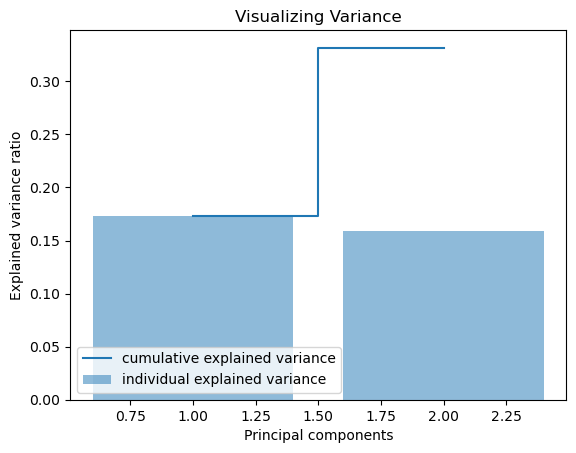

In [185]:
# Plot the explained variance ratio to understand how much variance is captured by each principal component
plt.bar(range(1, 3), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, 3), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.title("Visualizing Variance")
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

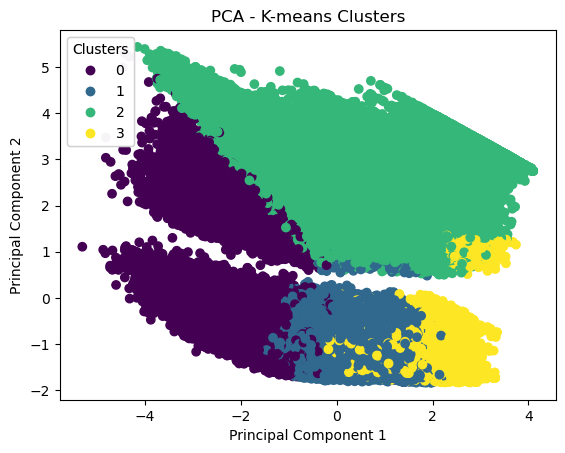

In [183]:
# Scatter plot of the PCA-reduced data
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=df_have_feature['cluster'], cmap='viridis')
plt.title('PCA - K-means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Adding a legend
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

plt.show()

Observations: It appears that the clusters are relatively well separated, which indicates that there are meaningful differences between the groups of users based on the features provided.

Nevertheless, additional analysis of the original features would be necessary to fully understand the characteristics of each cluster.

## 8-4 Evaluation Quality via Metrics

### Sanity Check: Given different K Values

In [186]:
def evaluate_kmeans(k, df):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df)

    silhouette_avg = silhouette_score(df, labels)
    inertia = kmeans.inertia_
    davies_bouldin_avg = davies_bouldin_score(df, labels)

    print(f"\nMetrics for k={k}:")
    print(f"Silhouette Score: {silhouette_avg:.4f}")
    print(f"Inertia: {inertia:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin_avg:.4f}")

In [187]:
# Evaluation for k=4
evaluate_kmeans(4, df)

# Evaluation for k=5
evaluate_kmeans(5, df)


Metrics for k=4:
Silhouette Score: 0.0887
Inertia: 3954494.3783
Davies-Bouldin Index: 2.1906

Metrics for k=5:
Silhouette Score: 0.1703
Inertia: 3611048.3063
Davies-Bouldin Index: 1.9899


Metrics for k=4:
Silhouette Score: 0.0887
Inertia: 3954494.3783
Davies-Bouldin Index: 2.1906

Metrics for k=5:
Silhouette Score: 0.1703
Inertia: 3611048.3063
Davies-Bouldin Index: 1.9899

The scores for k=4 are good overall, so let's keep 4 Clusters for our analysis

# 9 Cluster Analysis & Recommendation

In [202]:
df_have_feature.head()

,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,%GMV_Cancel_30D,avg_item_price,high_cancel_30%,cluster
0,VNLC22LL24,Fashion Accessories,Fashion,Eyewear,Frames & Glasses,0,9.929,1.000,0.000,0.355,0.453,0.192,0.000,0.000,9.929,0,3
1,VNLC22LL24,Menswear & Underwear,Fashion,Men's Tops,T-shirts,0,6.647,0.000,0.000,0.292,0.541,0.167,1.000,1.000,6.647,1,2
2,VNLC22LL6N,Food & Beverages,Grocery,Snacks,Popcorn,0,57.545,0.075,0.000,0.893,0.107,0.000,0.248,0.248,1.340,0,0
3,VNLC22LLBY,Food & Beverages,Grocery,Snacks,"Biscuits, Cookies & Wafers",0,143.019,0.111,1.000,0.487,0.399,0.114,0.252,0.252,1.837,0,0
4,VNLC22LLBY,Food & Beverages,Grocery,Snacks,"Biscuits, Cookies & Wafers",1,508.688,0.107,0.936,0.532,0.310,0.157,0.161,0.203,1.891,0,0


In [226]:
def cluster_analysis(x):
    # Create GMV-derived columns
    x['GMV_marketplace'] = x['%GMV_marketplace'] * x['GMV'] 
    x['GMV_affiliate'] = x['%GMV_affiliate'] * x['GMV']
    x['GMV_live'] = x['%GMV_live'] * x['GMV']  
    x['GMV_product_card'] = x['%GMV_product_card'] * x['GMV']  
    x['GMV_video'] = x['%GMV_video'] * x['GMV']  
    x['GMV_Cancel_1D'] = x['%GMV_Cancel_1D'] * x['GMV']  
    x['GMV_Cancel_30D'] = x['%GMV_Cancel_30D'] * x['GMV']

    # Industry: Highest GMV Industry per Cluster
    Industry_GMV = x.groupby(['cluster', 'industry'])['GMV'].sum().reset_index()
    highest_GMV_industries = Industry_GMV.sort_values(['cluster', 'GMV'], ascending=[True, False]).drop_duplicates('cluster')

    # Highest Cancel Industry per Cluster
    highest_cancel_industries = (
        x.groupby(['cluster', 'industry'])
        .agg({'GMV_Cancel_30D': 'sum', 'GMV': 'sum'})
        .reset_index()
        .assign(Cancel_Percent=lambda x: (x['GMV_Cancel_30D'] / x['GMV']) * 100)
        .sort_values(['cluster', 'Cancel_Percent'], ascending=[True, False])
        .drop_duplicates('cluster')
    )   

    # First Category: Highest GMV First Category per Cluster
    FirstCat_GMV = x.groupby(['cluster', 'first_cat'])['GMV'].sum().reset_index()
    highest_GMV_FirstCat = FirstCat_GMV.sort_values(['cluster', 'GMV'], ascending=[True, False]).drop_duplicates('cluster')

    # Highest Cancel First Category per Cluster
    highest_cancel_firstcat = (
        x.groupby(['cluster', 'first_cat'])
        .agg({'GMV_Cancel_30D': 'sum', 'GMV': 'sum'})
        .reset_index()
        .assign(Cancel_Percent=lambda x: (x['GMV_Cancel_30D'] / x['GMV']) * 100)
        .sort_values(['cluster', 'Cancel_Percent'], ascending=[True, False])
        .drop_duplicates('cluster')
    )   

    # Total store in each cluster, and stores with Account Manager in each cluster
    total_store = x[['cluster', 'storecode', 'have_accountmanager']].drop_duplicates()
    total_stores_in_cluster = total_store.groupby('cluster')['storecode'].nunique()
    store_have_am = total_store.groupby('cluster')['have_accountmanager'].sum()
    store_have_am_pct = store_have_am / total_stores_in_cluster

    # GMV Clusters
    GMV_cluster = x.groupby('cluster')['GMV'].sum()
    GMV_cluster_mean = x.groupby('cluster')['GMV'].mean()

    GMV_cancel_30D_cluster = x.groupby('cluster')['GMV_Cancel_30D'].sum()
    GMV_cancel_30D_pct_cluster = GMV_cancel_30D_cluster / GMV_cluster

    GMV_cancel_1D_cluster = x.groupby('cluster')['GMV_Cancel_1D'].sum()
    GMV_cancel_1D_pct_cluster = GMV_cancel_1D_cluster / GMV_cluster

    # Median sub-metrics
    GMV_marketplace_pct_median = x.groupby('cluster')['%GMV_marketplace'].mean()
    GMV_affiliate_pct_median = x.groupby('cluster')['%GMV_affiliate'].mean()
    GMV_live_pct_median = x.groupby('cluster')['%GMV_live'].mean()
    avg_item_price_median = x.groupby('cluster')['avg_item_price'].median()

    # High Cancellation After 30D Above 30% by Clusters
    total_store_high_cancel = x[x['high_cancel_30%'] > 0].groupby('cluster')['storecode'].nunique()


    # Merge all the metrics into a single DataFrame
    cluster_df = pd.DataFrame({
        'cluster': GMV_cluster.index,

        'GMV': GMV_cluster.values,
        'Highest GMV Industry': highest_GMV_industries['industry'].values,
        'Highest GMV Firstcat': highest_GMV_FirstCat['first_cat'].values,
        'GMV Mean per store': GMV_cluster_mean.values,
        'Total Stores': total_stores_in_cluster.values,
        '%Store have AM': store_have_am_pct.values,

        'GMV Cancelled after 30D': GMV_cancel_30D_pct_cluster.values,
        'GMV Cancelled after 1D': GMV_cancel_1D_pct_cluster.values,
        'Total Stores cancelled 30%+ ': total_store_high_cancel.values,
        'Highest Cancel Industry': highest_cancel_industries['industry'].values,
        'Highest Cancel Firstcat': highest_cancel_firstcat['first_cat'].values,
        
        'Median GMV Marketplace': GMV_marketplace_pct_median.values,
        'Median GMV Affiliate': GMV_affiliate_pct_median.values,
        'Median GMV live': GMV_live_pct_median.values,
        'Median Item Price': avg_item_price_median.values
    })

    return cluster_df

# Example usage
cluster_des = cluster_analysis(df_have_feature).transpose()
cluster_des.head(20)

,0,1,2,3
cluster,0,1,2,3
GMV,"84,267,493.748","6,439,311.668","5,080,518.952","513,781.998"
Highest GMV Industry,Electronics,Fashion,Electronics,Fashion
Highest GMV Firstcat,Phones & Electronics,Beauty & Personal Care,Phones & Electronics,Beauty & Personal Care
GMV Mean per store,808.065,70.693,73.571,10.455
Total Stores,42507,44692,46836,31339
%Store have AM,0.378,0.249,0.197,0.200
GMV Cancelled after 30D,0.262,0.143,0.759,0.038
GMV Cancelled after 1D,0.206,0.109,0.492,0.028
Total Stores cancelled 30%+,10435,127,46836,707


In [ ]:
##Cluster 0

Cluster 0 - **Electronics Growth**

Characteristics:
- High overall GMV with the largest share in **Phones & Electronics**.
- Moderate cancel rate after 30 days (26.2%), with **Jewelry & Accessories** as the category with the highest cancellation.
- Over one-third of stores have account management support.

Recommendations:
- Increase targeted promotions for **Jewelry & Accessories** to build customer trust in this category.
- Educate stores on setting realistic expectations for electronic accessories' availability and delivery times.
- Enhance **post-sale support** to reduce the need for cancellations.



In [ ]:
##Cluster 1

Cluster 1 - **Emerging Fashion**

Characteristics:
- Primarily a fashion cluster with **Beauty & Personal Care** as the highest GMV category.
- Moderate cancel rate after 30 days (14.3%) and relatively lower cancel rates compared to other clusters.
- Low GMV per store indicates smaller, potentially newer or boutique sellers.

Recommendations:
- Improve inventory and supply chain support for fashion sellers to further decrease cancel rates.
- Develop an **onboarding program** tailored to help emerging stores optimize their listings and inventory levels.
- Offer **promotional support** for Beauty & Personal Care and **Collectibles** (highest cancel categories) to improve buyer confidence.



In [ ]:
##Cluster 2

Cluster 2 - **High-Cancel Electronics**

Characteristics:
- Highest cancellation rate across all clusters (75.9%), especially in **Phones & Electronics**.
- Very low percentage of stores with account management support (19.7%).
- Low GMV per store suggests these may be smaller or less-established sellers.

Recommendations:
- Implement a **high-touch account management program** for this cluster to improve seller practices and reduce cancellations.
- Focus on **inventory management training** for sellers in Phones & Electronics.
- Consider stricter entry requirements or **screening processes** for electronics sellers to ensure higher quality and reliability.



In [ ]:
##Cluster 3

Cluster 3 - **Niche Fashion**

Characteristics:
- Smallest GMV and lowest cancel rate (3.8%) of all clusters, focused in **Beauty & Personal Care**.
- Relatively low GMV per store, indicating niche or boutique offerings.
- **Collectibles** category shows the highest cancel rate but is less impactful overall.

Recommendations:
- Provide **niche marketing support** to grow GMV for specialty stores.
- Encourage stores in **Collectibles** to better manage customer expectations regarding rare or unique items.
- Promote customer reviews and ratings to build credibility for niche stores and maintain low cancellation rates.